![](http://)이 커널은 [Extensive EDA and Modeling XGB Hyperopt](https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt) 를 한글로 번역한 커널입니다.

# Competition Objective is to detect fraud in Transactions

### Data
이 대회에서 당신은 온라인 거래가 사기인지에 대한 확률을 Binary Target인 isFraud로 예측합니다.

데이터는 identity와 transaction 두 개의 파일로 나눠져있고, TransactionID를 이용하여 조인되어 있습니다.
> 모든 거래가 해당 개인정보를 가지고 있는 것은 아닙니다.

카테고리 특성 - Transaction
- ProductCD
- emaildomain
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M2

카테고리 특성 - Identity
- DeviceType
- DeviceInfo
- id_12 - id_38

The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).

## Questions
저는 범주형 특성과 거래 금액에 따라 EDA를 시작할 것입니다. EDA의 목표는 다음과 같은 몇가지 질문에 대한 답변입니다.

- 우리가 가진 데이터는 어떤 유형의 데이터인가?
- 데이터의 크기는 어느 정도이고, 결측값은 얼마나 되는가?
- Target variable의 분포는 어떠한가?
- 사기 거래와 정상적인 거래의 금액분포는 어떠한가?
- 주요 사기 제품들이 존재하는가?
- Features와 Target이 흥미로운 패턴을 보여주는가?
- 그리고 EDA를 통해 더 많은 질문이 제기될 것입니다.


### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import plotly.figure_factory as ff

# 전처리, 모델링, 평가
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

# Defining the HyperOpt function with parameters space and model
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
from sklearn.metrics import make_scorer
# Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc
import time
print(os.listdir("../input"))

['ieee-fraud-detection']


### Importing train dataset

In [2]:
df_id = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv')
df_trans = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv')

생성한 모든 함수는 아래 셀에 정의할 것입니다.

In [3]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary
    
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

In [4]:
# 메모리 점유율 감소시키기
df_trans = reduce_mem_usage(df_trans)
df_id = reduce_mem_usage(df_id)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)


### Knowing the data

In [5]:
resumetable(df_trans)[:25]

Dataset Shape: (590540, 394)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int32,0,590540,2987000,2987001,2987002,19.17
1,isFraud,int8,0,2,0,0,0,0.22
2,TransactionDT,int32,0,573349,86400,86401,86469,19.11
3,TransactionAmt,float16,0,8195,68.5,29,59,8.10
4,ProductCD,object,0,5,W,W,W,1.28
5,card1,int16,0,13553,13926,2755,4663,9.97
6,card2,float16,8933,500,NaN,404,490,6.32
7,card3,float16,1565,114,150,150,150,0.68
8,card4,object,1577,4,discover,mastercard,visa,1.09
9,card5,float16,4259,119,142,102,166,2.66


### Target Distribution

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



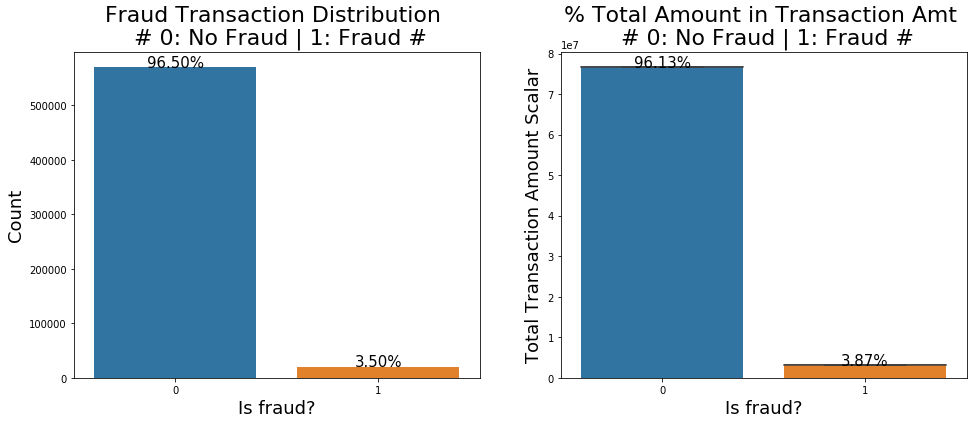

In [6]:
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
total = len(df_trans)
total_amt = df_trans.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(16,6))

plt.subplot(121)
g = sns.countplot(x = 'isFraud', data = df_trans,)
g.set_title("Fraud Transaction Distribution \n # 0: No Fraud | 1: Fraud #",fontsize=22)
g.set_xlabel("Is fraud?",fontsize = 18)
g.set_ylabel("Count", fontsize = 18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
          height + 3,
          '{:1.2f}%'.format(height/total*100),
          ha = "center",fontsize = 15)
    
perc_amt = (df_trans.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.boxplot(x = 'isFraud', y = 'TransactionAmt',dodge = True, data = perc_amt)
plt.subplot(122)
g1 = sns.barplot(x = 'isFraud', y = 'TransactionAmt', dodge = True, data = perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n # 0: No Fraud | 1: Fraud #", fontsize =22)
g1.set_xlabel('Is fraud?',fontsize = 18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize = 18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2,
           height + 3,
           '{:1.2f}%'.format(height/total_amt*100),
           ha = 'center', fontsize = 15)


주어진 데이터 내에서 3.5%는 사기 거래 데이터입니다. 
구매 금액 비율이 전체의 3.5%보다 높을지 낮을지 보는 것은 흥미로을 것이라 생각이 듭니다. 
총 구매 금액도 거의 비슷한 비율을 보이고 있습니다.
이제 거래 금액을 살펴 보겠습니다.

### Transaction Amount Quantiles
거래 금액에 대한 플롯을 보이기 전에, 분위수를 먼저 살펴보겠습니다.

In [7]:
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
print('Transaction Amounts Quantiles:')
print(df_trans['TransactionAmt'].quantile([.01,.025,.1,.25,.5,.75,.9,.975,.99]))

Transaction Amounts Quantiles:
0.010       9.242188
0.025      14.500000
0.100      25.953125
0.250      43.312500
0.500      68.750000
0.750     125.000000
0.900     275.250000
0.975     648.262500
0.990    1104.000000
Name: TransactionAmt, dtype: float64


### Ploting Transaction Amount Values Distribution

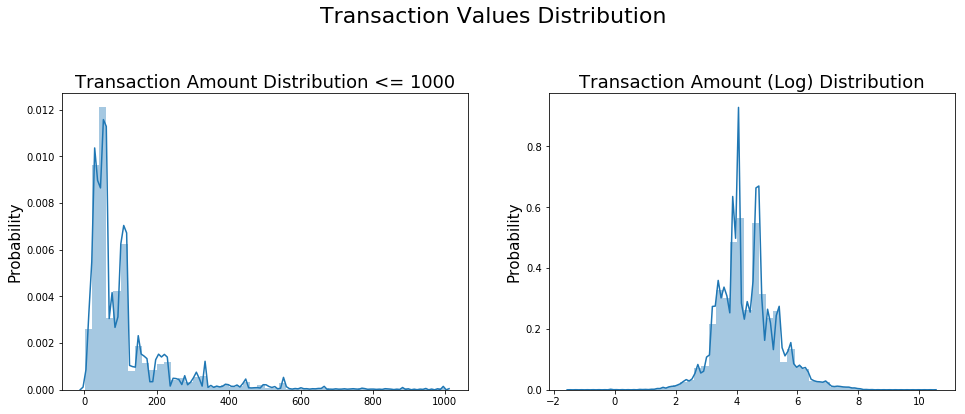

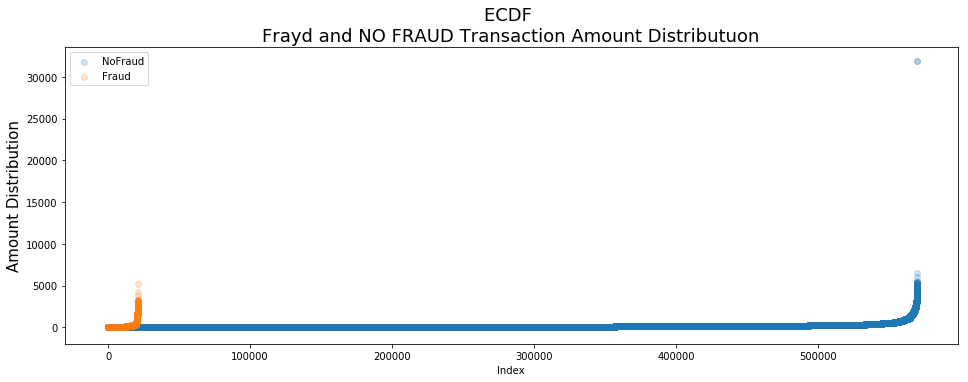

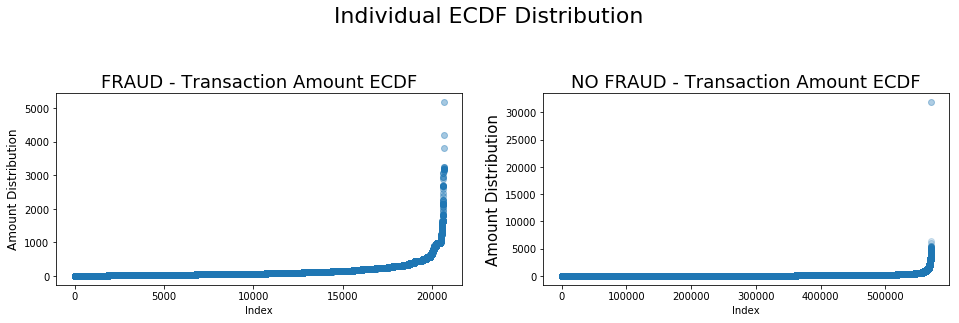

In [8]:
plt.figure(figsize = (16,12))
plt.suptitle('Transaction Values Distribution', fontsize = 22)
plt.subplot(221)
g = sns.distplot(df_trans[df_trans['TransactionAmt'] <=1000]['TransactionAmt'])
g.set_title('Transaction Amount Distribution <= 1000',fontsize=18)
g.set_xlabel("")
g.set_ylabel('Probability',fontsize = 15)

plt.subplot(222)
g1 = sns.distplot(np.log(df_trans['TransactionAmt']))
g1.set_title('Transaction Amount (Log) Distribution',fontsize = 18)
g1.set_xlabel("")
g1.set_ylabel("Probability",fontsize=15)

plt.figure(figsize = (16,12))

plt.subplot(212)
g4 = plt.scatter(range(df_trans[df_trans['isFraud'] ==0].shape[0]),
                np.sort(df_trans[df_trans['isFraud'] == 0]['TransactionAmt'].values),
                label = 'NoFraud', alpha = .2)
g4 = plt.scatter(range(df_trans[df_trans['isFraud'] == 1].shape[0]),
                np.sort(df_trans[df_trans['isFraud'] == 1]['TransactionAmt'].values),
                label = 'Fraud', alpha = .2)
g4 = plt.title("ECDF \nFrayd and NO FRAUD Transaction Amount Distributuon",fontsize = 18)
g4 = plt.xlabel('Index')
g4 = plt.ylabel('Amount Distribution', fontsize = 15)
g4 = plt.legend()

plt.figure(figsize =(16,12))

plt.subplot(321)
g = plt.scatter(range(df_trans[df_trans['isFraud'] == 1].shape[0]),
               np.sort(df_trans[df_trans['isFraud'] ==1]['TransactionAmt'].values),
               label = 'isFraud', alpha = .4)
plt.title("FRAUD - Transaction Amount ECDF", fontsize = 18)
plt.xlabel('Index')
plt.ylabel('Amount Distribution', fontsize = 12)

plt.subplot(322)
g1 = plt.scatter(range(df_trans[df_trans['isFraud'] == 0].shape[0]),
                np.sort(df_trans[df_trans['isFraud'] == 0]['TransactionAmt'].values),
                label = 'NoFraud', alpha = .2)
g1 = plt.title("NO FRAUD - Transaction Amount ECDF", fontsize = 18)
g1 = plt.xlabel("Index")
g1 = plt.ylabel("Amount Distribution", fontsize = 15)

plt.suptitle('Individual ECDF Distribution', fontsize = 22)
plt.show()



### Seeing the Quantiles of Fraud and No Fraud Transactions

In [9]:
print(pd.concat([df_trans[df_trans['isFraud']==1]['TransactionAmt']\
                .quantile([.01, .1, .25, .5, .75, .9,.99])\
                .reset_index(),
                df_trans[df_trans['isFraud']==0]['TransactionAmt']\
                .quantile([.01, .1, .25, .5, .75, .9, .99])\
                .reset_index()],
               axis = 1, keys = ['Fraud','No Fraud']))

  Fraud                No Fraud               
  index TransactionAmt    index TransactionAmt
0  0.01       6.739453     0.01       9.511875
1  0.10      18.937500     0.10      26.312500
2  0.25      35.031250     0.25      43.968750
3  0.50      75.000000     0.50      68.500000
4  0.75     161.000000     0.75     120.000000
5  0.90     335.000000     0.90     267.100000
6  0.99     994.000000     0.99    1104.000000


### Transaction Amount Outliers
- 이상치는 평균에서 표준편차의 3배이상의 값들로 고려합니다. 

In [10]:
CalcOutliers(df_trans['TransactionAmt'])

Identified lowest outliers: 0
Identified upper outliers: 10097
Total outlier observations: 10097
Non-outlier observations: 580443
Total percentual of Outliers:  1.7395


우리가 0에서 800사이의 값들만 고려한다면, Outiler를 피할 것이고 우리의 분포에 대해 더 확신을 가질 수 있을 것입니다.

우리는 약 10000개의 Outlier을 가지고 있고, 이는 전체의 1.74% 입니다.

### Now, let's known the Product Feature
- 제품의 분포
- 제품별 사기 거래의 분포
- 제품군에 따른 거래금액간 차이가 존재하는가?

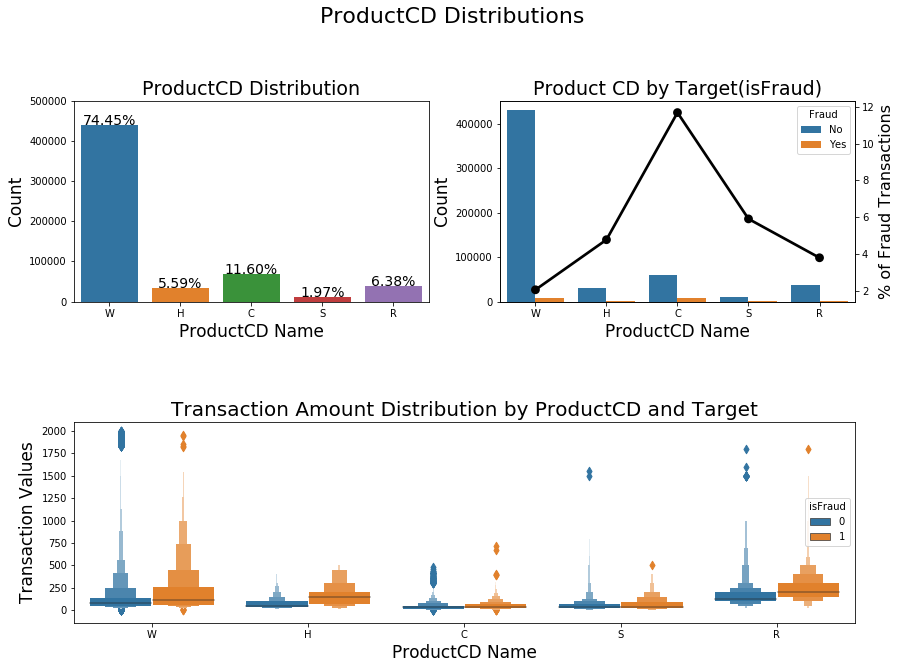

In [11]:
tmp = pd.crosstab(df_trans['ProductCD'], df_trans['isFraud'], normalize = 'index') * 100
tmp = tmp.reset_index()
tmp.rename(columns = {0: "NoFraud", 1:"Fraud"}, inplace = True)

plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x = 'ProductCD', data = df_trans)

g.set_title('ProductCD Distribution', fontsize = 19)
g.set_xlabel('ProductCD Name',fontsize = 17)
g.set_ylabel('Count',fontsize = 17)
g.set_ylim(0,500000)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
          height + 3,
          '{:1.2f}%'.format(height/total*100),
          ha = "center",fontsize =14)
    
plt.subplot(222)
g1 = sns.countplot(x = 'ProductCD',hue = 'isFraud', data = df_trans)
plt.legend(title = 'Fraud',loc = 'best', labels = ['No','Yes'])
gt = g1.twinx()
gt = sns.pointplot(x = 'ProductCD', y = 'Fraud', data = tmp, color ='black',
                  order = ['W','H','C','S','R'],legend = False)
gt.set_ylabel('% of Fraud Transactions', fontsize = 16)
g1.set_title("Product CD by Target(isFraud)", fontsize = 19)
g1.set_xlabel("ProductCD Name", fontsize = 17)
g1.set_ylabel("Count",fontsize = 17)

plt.subplot(212)
g3 = sns.boxenplot(x = 'ProductCD', y= 'TransactionAmt',hue = 'isFraud',
                  data = df_trans[df_trans['TransactionAmt']<2000])
g3.set_title('Transaction Amount Distribution by ProductCD and Target',fontsize = 20)
g3.set_xlabel("ProductCD Name",fontsize = 17)
g3.set_ylabel("Transaction Values", fontsize = 17)

plt.subplots_adjust(hspace = .6, top = .85)
plt.show()

W,C,R,H,S 순으로 빈도가 가장 높았습니다.

W,H,R의 사기 거래값의 분포는 정상적인 거래값보다 높았습니다.


### Card Features
- 이 대회의 설명에 따르면, 카드 변수는 Categorical 변수입니다.
- 값의 분포를 이해할 필요가 있습니다.
- 
- 카드 변수는 6개의 column을 가지고 있고 이 중 4개는 수치형 변수로 보인다. 따라서 분위수와 분포를 확인해볼 필요가 있다.

In [12]:
resumetable(df_trans[['card1','card2','card3','card4','card5','card6']])

Dataset Shape: (590540, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,card1,int16,0,13553,13926,2755,4663,9.97
1,card2,float16,8933,500,NaN,404,490,6.32
2,card3,float16,1565,114,150,150,150,0.68
3,card4,object,1577,4,discover,mastercard,visa,1.09
4,card5,float16,4259,119,142,102,166,2.66
5,card6,object,1571,4,credit,credit,debit,0.82


Card2부터 Card6는 결측값을 가지고 있습니다. 차후에 이를 다를 필요가 있을 것입니다.

In [13]:
print("Card Feature Quantile")
print(df_trans[['card1','card2','card3','card5']].quantile([0.01,0.025,0.1,0.25,0.5,0.75,0.975,0.99]))

Card Feature Quantile
         card1  card2  card3  card5
0.010   1338.0  100.0  144.0  102.0
0.025   1675.0  111.0  150.0  102.0
0.100   2803.0  111.0  150.0  126.0
0.250   6019.0  214.0  150.0  166.0
0.500   9678.0  361.0  150.0  226.0
0.750  14184.0  512.0  150.0  226.0
0.975  18018.0  583.0  185.0  226.0
0.990  18238.0  583.0  185.0  226.0


Card1과 Card2의 분포가 매우 넓다는 것을 알 수 있습니다. 따라서 로그 변환을 시켜주는 것이 더 좋을 것이라 할 수 있습니다.

In [14]:
df_trans.loc[df_trans.card3.isin(df_trans.card3.value_counts()[df_trans.card3.value_counts() < 200].index),
            'card3'] = 'Others'
df_trans.loc[df_trans.card5.isin(df_trans.card5.value_counts()[df_trans.card5.value_counts() < 300].index),
             'card5'] = 'Others'

### Visualizaing Card 1, Card 2 and Card3 Distribution
- Card1과 Card2가 수치형이기 때문에, 이에 대한 분포를 확인하겠습니다.
- Card3 같은 경우, 많은 값들이 낮은 빈도로 나타났기 때문에, Others를 부여하기로 결정했습니다.
- Also, in Card 3 I set the % of Fraud ratio in yaxis2

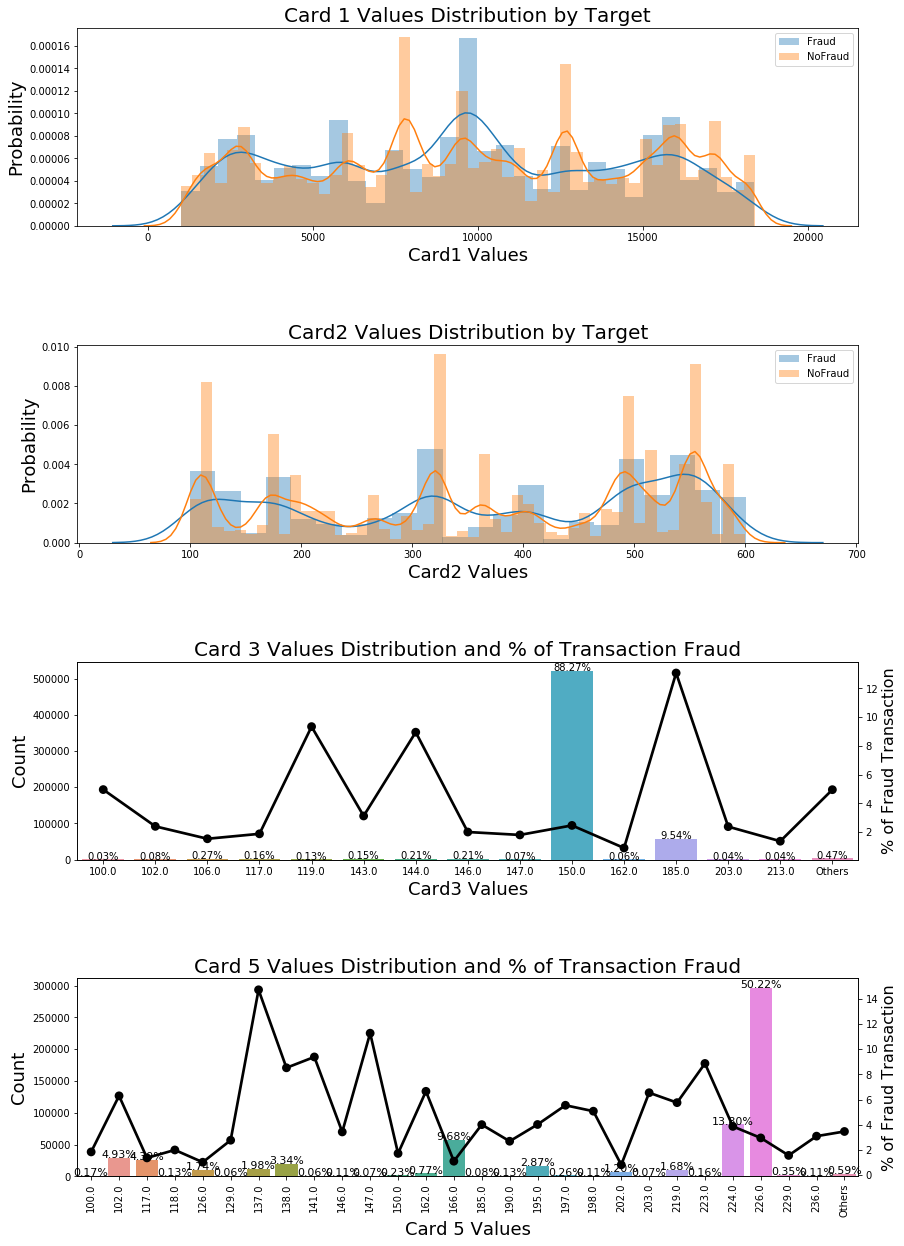

In [15]:
tmp = pd.crosstab(df_trans['card3'], df_trans['isFraud'], normalize = 'index')*100
tmp = tmp.reset_index()
tmp.rename(columns = {0: 'NoFraud', 1:'Fraud'}, inplace= True)

tmp2 = pd.crosstab(df_trans['card5'], df_trans['isFraud'], normalize = 'index')*100
tmp2 = tmp2.reset_index()
tmp2.rename(columns = {0: 'NoFraud', 1: 'Fraud'}, inplace = True)

plt.figure(figsize = (14,22))

plt.subplot(411)
g = sns.distplot(df_trans[df_trans['isFraud']==1]['card1'],label = 'Fraud')
g = sns.distplot(df_trans[df_trans['isFraud']==0]['card1'],label = 'NoFraud')
g.legend()
g.set_title('Card 1 Values Distribution by Target', fontsize = 20)
g.set_xlabel('Card1 Values',fontsize = 18)
g.set_ylabel('Probability',fontsize = 18)

plt.subplot(412)
g1 = sns.distplot(df_trans[df_trans['isFraud'] == 1]['card2'].dropna(),label = 'Fraud')
g1 = sns.distplot(df_trans[df_trans['isFraud'] == 0]['card2'].dropna(),label = 'NoFraud')
g1.legend()
g1.set_title("Card2 Values Distribution by Target", fontsize = 20)
g1.set_xlabel('Card2 Values',fontsize = 18)
g1.set_ylabel('Probability', fontsize = 18)

plt.subplot(413)
g2 = sns.countplot(x = 'card3',data = df_trans, order = list(tmp.card3.values))
g22 = g2.twinx()
gg2 = sns.pointplot(x = 'card3', y= 'Fraud', data = tmp,
                   color = 'black', order = list(tmp.card3.values))
gg2.set_ylabel('% of Fraud Transaction',fontsize = 16)
g2.set_title('Card 3 Values Distribution and % of Transaction Fraud',fontsize= 20)
g2.set_xlabel('Card3 Values',fontsize = 18)
g2.set_ylabel('Count', fontsize = 18)

for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
           height + 25,
           '{:1.2f}%'.format(height/total*100),
           ha = 'center')
    
plt.subplot(414)
g3 = sns.countplot(x = 'card5', data = df_trans, order = list(tmp2.card5.values))
g3t = g3.twinx()
g3t = sns.pointplot(x = 'card5', y = 'Fraud', data = tmp2,
                   color = 'black', order = list(tmp2.card5.values))
g3t.set_ylabel('% of Fraud Transaction', fontsize = 16)
g3.set_title("Card 5 Values Distribution and % of Transaction Fraud",fontsize = 20)
g3.set_xticklabels(g3.get_xticklabels(), rotation = 90)
g3.set_xlabel('Card 5 Values',fontsize = 18)
g3.set_ylabel('Count',fontsize = 18)

for p in g3.patches:
    height = p.get_height()
    g3.text(p.get_x()+p.get_width()/2.,
           height + 3,
           '{:1.2f}%'.format(height/total*100),
           ha = 'center', fontsize = 11)

plt.subplots_adjust(hspace = 0.6, top = 0.85)
    

상당히 의미있는 정보입니다!
- Card3에서 100과 106이 Column 내에서 가장 비슷한 값을 가지고 있다는 것을 알 수 있습니다.
- 100에서 4.95%의 사기 거래가 존재했고, 106에서는 1.52%가 존재했습니다. 가장 높은 사기 거래율은 185, 119, 144에서 나타났습니다.
- Card5에서 가장 빈도수가 높은 값을 가진 226, 224, 166은 전체의 데이터의 73%를 표현하고 있습니다. 또한 높은 사기 거래율을 보이는 137, 147, 141은 빈도가 매우 낮았습니다.


### Card4 - Categorical

In [16]:
tmp = pd.crosstab(df_trans['card4'], df_trans['isFraud'], normalize = 'index')* 100
tmp = tmp.reset_index()
tmp

isFraud,card4,0,1
0,american express,97.130163,2.869837
1,discover,92.271839,7.728161
2,mastercard,96.566905,3.433095
3,visa,96.524390,3.475610


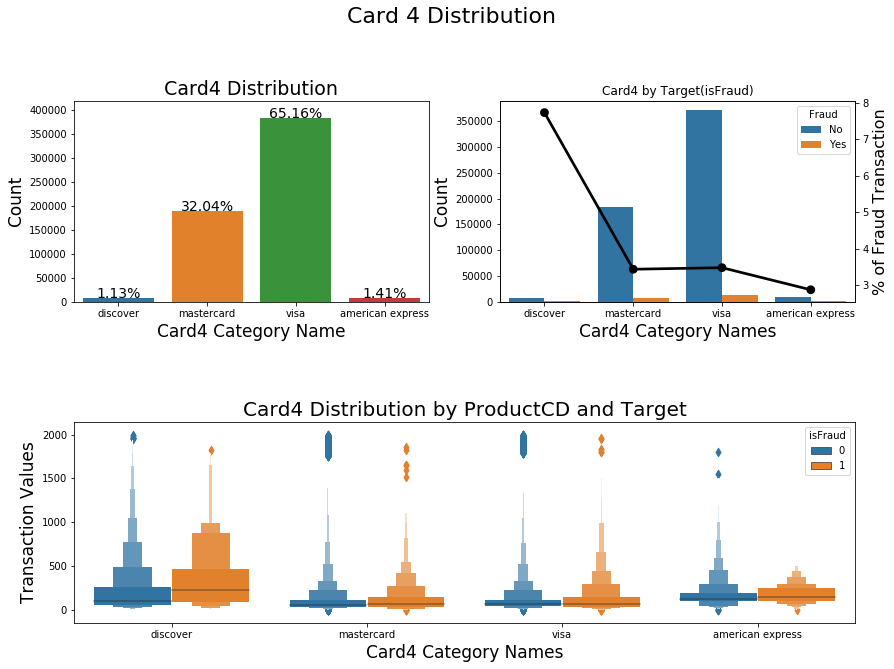

In [17]:
tmp = pd.crosstab(df_trans['card4'], df_trans['isFraud'], normalize = 'index')* 100
tmp = tmp.reset_index()
tmp.rename(columns = {0:'NoFraud',1:'Fraud'}, inplace = True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 4 Distribution',fontsize = 22)

plt.subplot(221)
g = sns.countplot(x = 'card4', data =df_trans)
g.set_title('Card4 Distribution', fontsize = 19)
g.set_ylim(0,420000)
g.set_xlabel('Card4 Category Name',fontsize = 17)
g.set_ylabel('Count',fontsize = 17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
          height + 3,
          '{:1.2f}%'.format(height/total*100),
          ha = 'center',fontsize = 14)

plt.subplot(222)
g1 = sns.countplot(x = 'card4', hue = 'isFraud', data = df_trans)
plt.legend(title = 'Fraud', loc = 'best', labels = ['No','Yes'])
gt = g1.twinx()
gt = sns.pointplot(x = 'card4', y = 'Fraud', data = tmp,
                  color = 'black', legend = False,
                  order = ['discover','mastercard','visa', 'american express'])
gt.set_ylabel('% of Fraud Transaction',fontsize = 16)
g1.set_xlabel('Card4 Category Names', fontsize = 17)
g1.set_title('Card4 by Target(isFraud)')
g1.set_ylabel('Count',fontsize = 17)

plt.subplot(212)
g3 = sns.boxenplot(x = 'card4', y = 'TransactionAmt', hue = 'isFraud',
                data = df_trans[df_trans['TransactionAmt'] < 2000])
g3.set_title('Card4 Distribution by ProductCD and Target',fontsize =20)
g3.set_xlabel('Card4 Category Names',fontsize = 17)
g3.set_ylabel('Transaction Values', fontsize = 17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

- 97%의 데이터가 Visacard(65%)와 Mastercard(32%)로 이루어져 있다는 것을 알 수 있습니다.
- Discover 내에서 약 8%의 사기 거래가 탐지되었고, Mastercard와 Visscard에서 약 3.5%, American Express에서 2.87%의 사기 거래가 탐지되었다는 것을 알 수 있습니다.  

### Card6 - Categorical

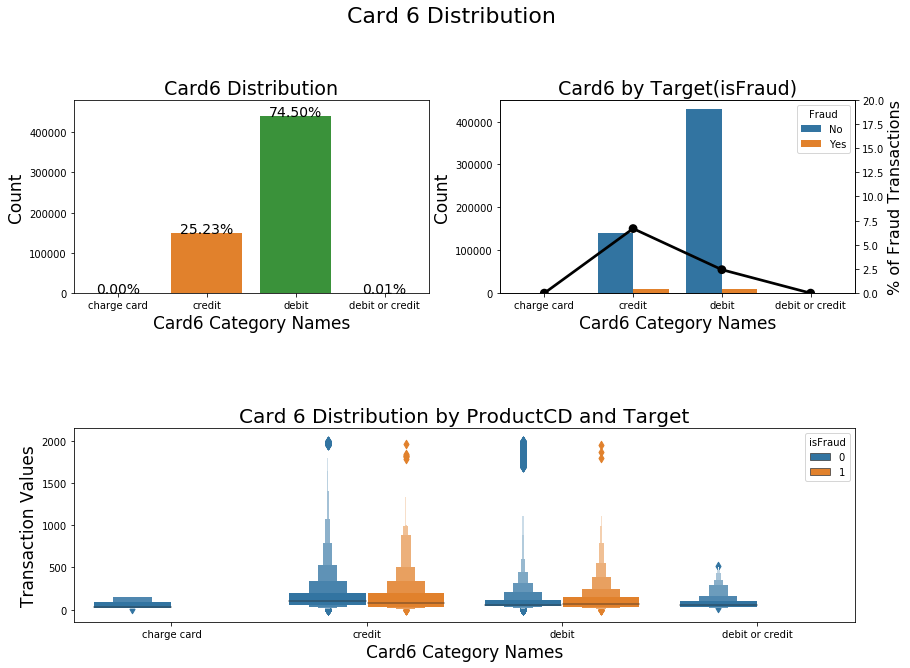

In [18]:
tmp = pd.crosstab(df_trans['card6'], df_trans['isFraud'], normalize = 'index') * 100
tmp = tmp.reset_index()
tmp.rename(columns = {0:'NoFraud',1:'Fraud'}, inplace= True)

plt.figure(figsize = (14,10))
plt.suptitle('Card 6 Distribution', fontsize = 22)

plt.subplot(221)
g = sns.countplot(x = 'card6', data = df_trans, order = list(tmp.card6.values))
g.set_title('Card6 Distribution', fontsize = 19)
g.set_ylim(0,480000)
g.set_xlabel('Card6 Category Names',fontsize = 17)
g.set_ylabel('Count', fontsize = 17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
          height + 3,
          '{:1.2f}%'.format(height/total*100),
          ha = 'center', fontsize = 14)

plt.subplot(222)
g1 = sns.countplot(x = 'card6', hue = 'isFraud', data = df_trans, order = list(tmp.card6.values))
plt.legend(title = 'Fraud', loc = 'best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x = 'card6', y = 'Fraud', data =tmp, order = list(tmp.card6.values),
                  color = 'black', legend = False)
gt.set_ylim(0,20)
gt.set_ylabel('% of Fraud Transactions', fontsize = 16)
g1.set_title('Card6 by Target(isFraud)',fontsize = 19)
g1.set_xlabel('Card6 Category Names', fontsize = 17)
g1.set_ylabel('Count', fontsize = 17)

plt.subplot(212)
g3 = sns.boxenplot(x = 'card6', y = 'TransactionAmt', hue = 'isFraud', order = list(tmp.card6.values),
                  data = df_trans[df_trans['TransactionAmt'] <=2000])
g3.set_title('Card 6 Distribution by ProductCD and Target', fontsize = 20)
g3.set_xlabel('Card6 Category Names',fontsize = 17)
g3.set_ylabel('Transaction Values',fontsize = 17)

plt.subplots_adjust(hspace = 0.7, top = 0.85)
plt.show()

- 모든 데이터는 Credit card이거나 Debit card입니다. 또한 사기 비율은 Cardit card 거래가 Debit card보다 높은 것을 알 수 있ㅅ브니다.
- 거래 금액의 분포는 큰 차이를 보이지 않는다는 것을 알 수 있습니다.

## Exploring M1-M9 Features

In [19]:
for col in ['M1','M2','M3','M4','M5','M6','M7','M8','M9']:
    df_trans[col] = df_trans[col].fillna('Miss')

def ploting_dist_ratio(df,col, lim=2000):
    tmp = pd.crosstab(df[col],df['isFraud'], normalize = 'index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud',1:'Fraud'}, inplace = True)
    
    plt.figure(figsize = (20,5))
    plt.suptitle(f'{col} Distributions', fontsize = 22)
    
    plt.subplot(121)
    g = sns.countplot(x = col, data = df, order = list(tmp[col].values))
    g.set_title(f"{col} Distribution \n Count and %Fraud by each category", fontsize = 18)
    g.set_ylim(0,400000)
    gt = g.twinx()
    gt = sns.pointplot(x = col, y = 'Fraud', data = tmp, order = list(tmp[col].values),
                      color = 'black', legend = False,)
    gt.set_ylim(0,20)
    gt.set_ylabel('% of Fraud Transactions', fontsize = 16)
    g.set_xlabel(f"{col} Category Names", fontsize = 16)
    g.set_ylabel("Count", fontsize = 17)
    for p in gt.patches:
        height = p.get_height()
        gt.text(p.get_x() + p.get_width()/2.,
               height + 3,
               '{:1.2f}%'.format(height/total*100),
               ha = "center", fontsize = 14)
    
    perc_amt = (df_trans.groupby(['isFraud', col])['TransactionAmt'].sum() / total_amt*100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns = {0:'NoFraud',1:'Fraud'}, inplace = True)
    
    plt.subplot(122)
    g1 = sns.boxplot(x=col, y = 'TransactionAmt', hue = 'isFraud', data = df[df['TransactionAmt']<=lim],order = list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x = col, y = 'Fraud',data = perc_amt, order = list(tmp[col].values),
                       color = 'black', legend = False,)
    g1t.set_ylim(0,5)
    g1t.set_ylabel('%Fraud Total Amount', fontsize = 16)
    g1.set_title(f"{col} by Transaction dist", fontsize = 18)
    g1.set_xlabel(f"{col} Category Names",fontsize = 16)
    g1.set_ylabel("Transaction Amount(U$)",fontsize = 16)
    
    plt.subplots_adjust(hspace = .4, wspace = 0.35, top = 0.8)
    plt.show()

### M distribution: Count, %Fraud and Transaction Amount Distribution

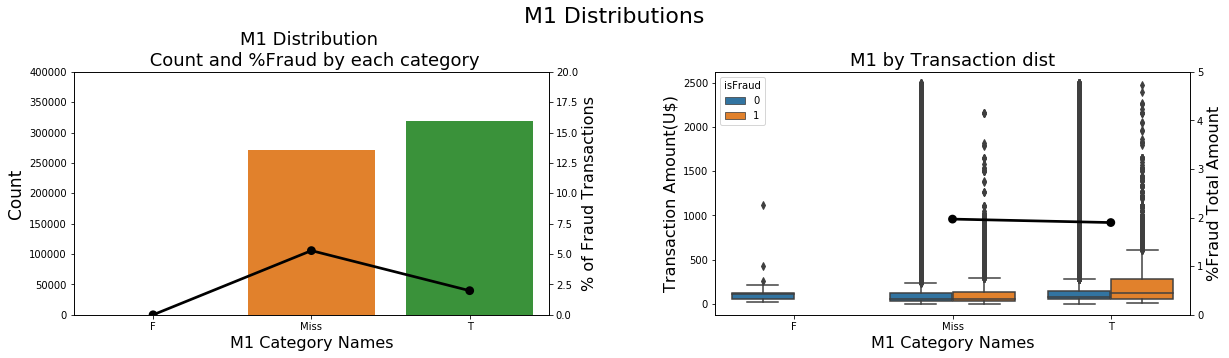

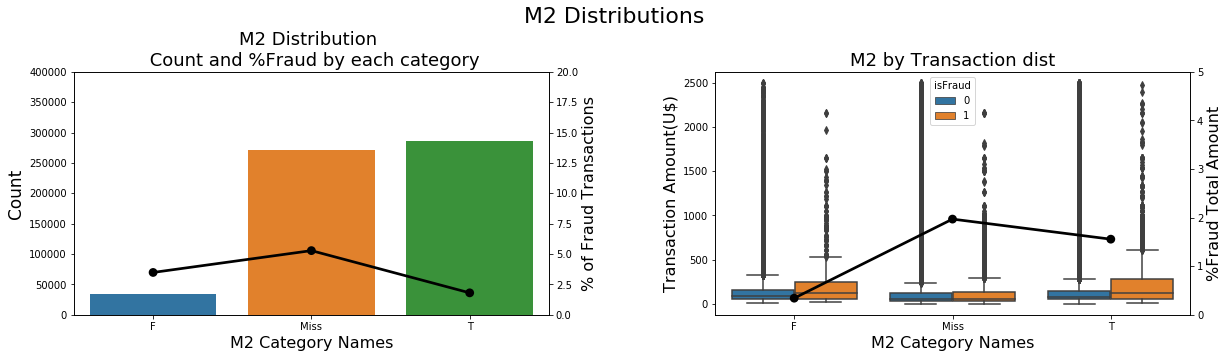

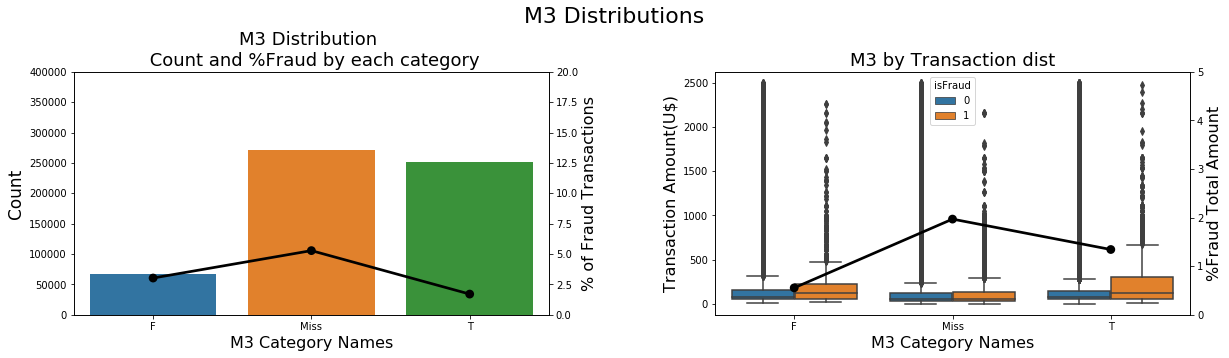

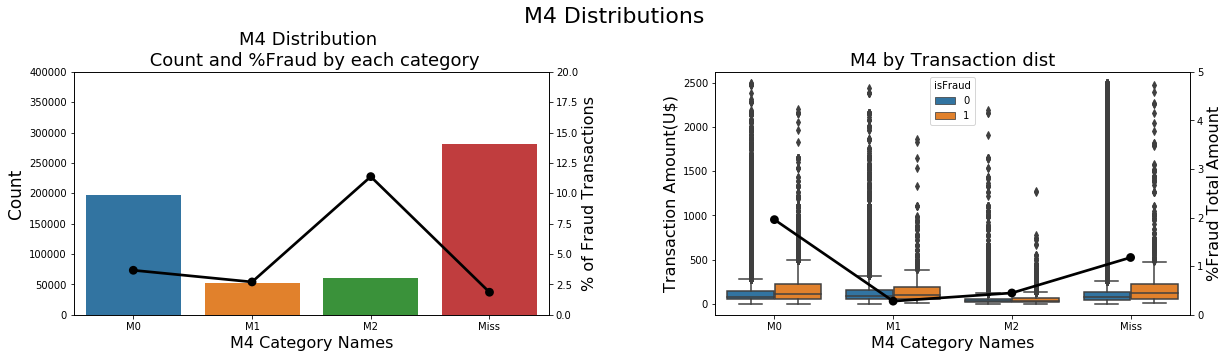

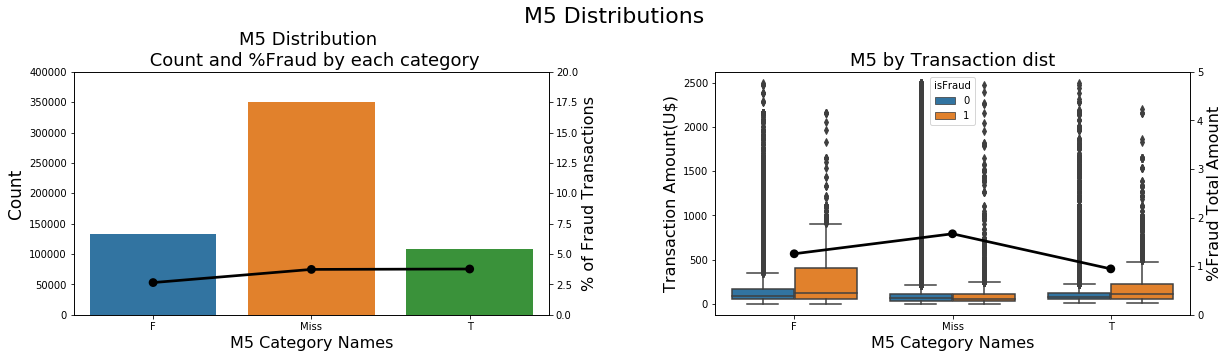

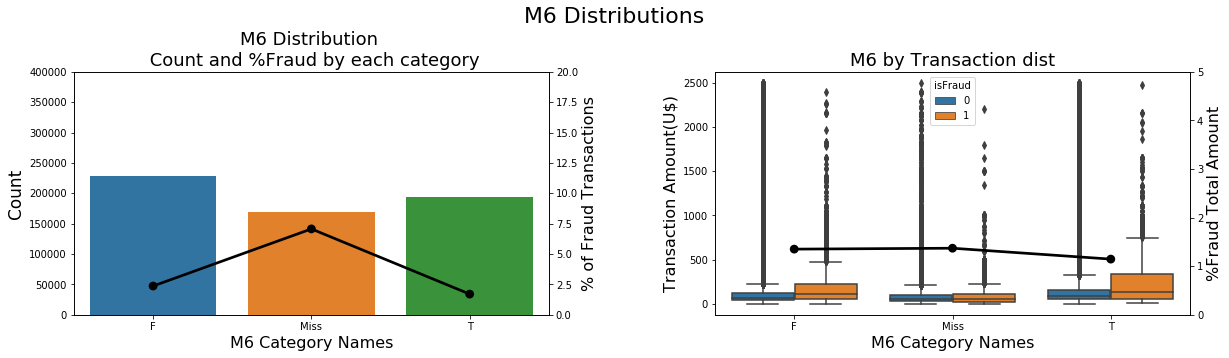

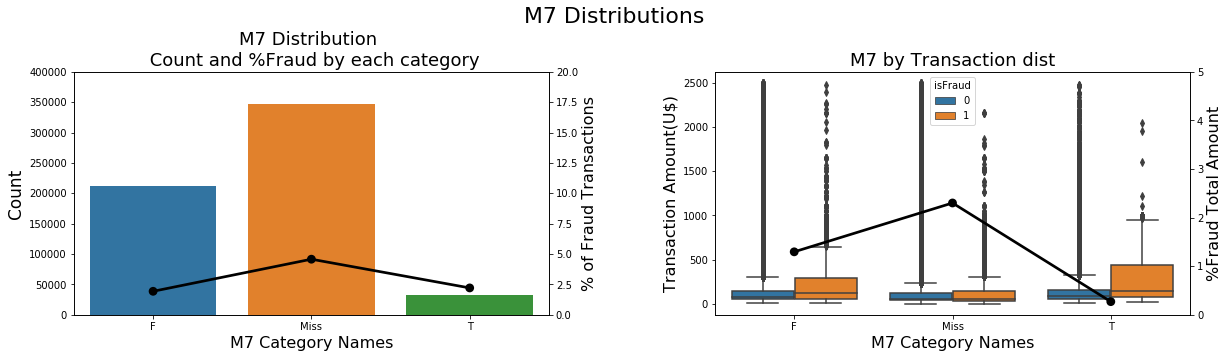

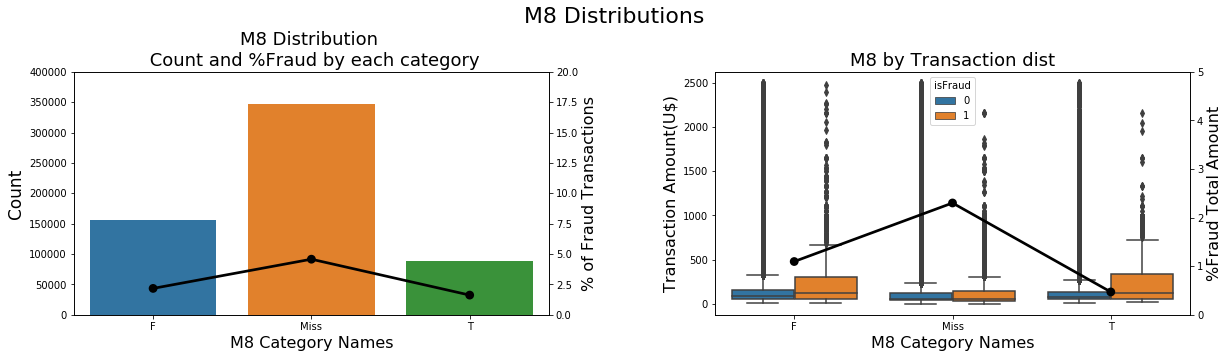

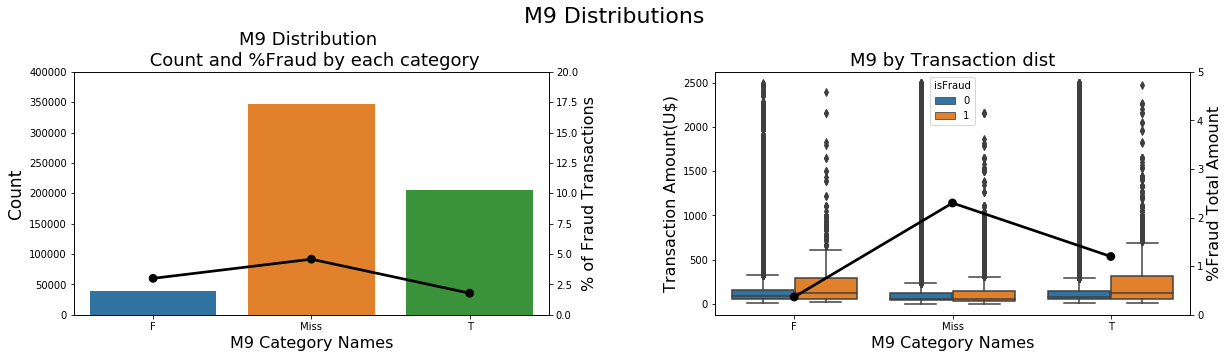

In [20]:
for col in ['M1','M2','M3','M4','M5','M6','M7','M8','M9']:
    ploting_dist_ratio(df_trans,col,lim=2500)

놀라운 사실을 알 수 있습니다. M4에서만 결측값이 나타났고, 이 결측값은 사기율이 가장 낮았습니다.

### Addr1 and Addr2

In [21]:
print("Card Features Quantiles:")
print(df_trans[['addr1','addr2']].quantile([0.01,0.025,0.1,0.25,0.5,0.75,0.9,0.975,0.99]))

Card Features Quantiles:
       addr1  addr2
0.010  123.0   87.0
0.025  123.0   87.0
0.100  177.0   87.0
0.250  204.0   87.0
0.500  299.0   87.0
0.750  330.0   87.0
0.900  441.0   87.0
0.975  498.0   87.0
0.990  512.0   87.0


5000 이하인 Addr1의 모든 값을 "Others"로 설정합니다.  
마찬가지로, Addr2에서 50 이하인 모든 값을 "Others"로 설정합니다.

In [22]:
df_trans.loc[df_trans.addr1.isin(df_trans.addr1.value_counts()[df_trans.addr1.value_counts() <= 5000].index), 'addr1'] = 'Others'
df_trans.loc[df_trans.addr2.isin(df_trans.addr2.value_counts()[df_trans.addr2.value_counts() <= 50].index), 'addr2'] = 'Others'

### Addr1 Distributions

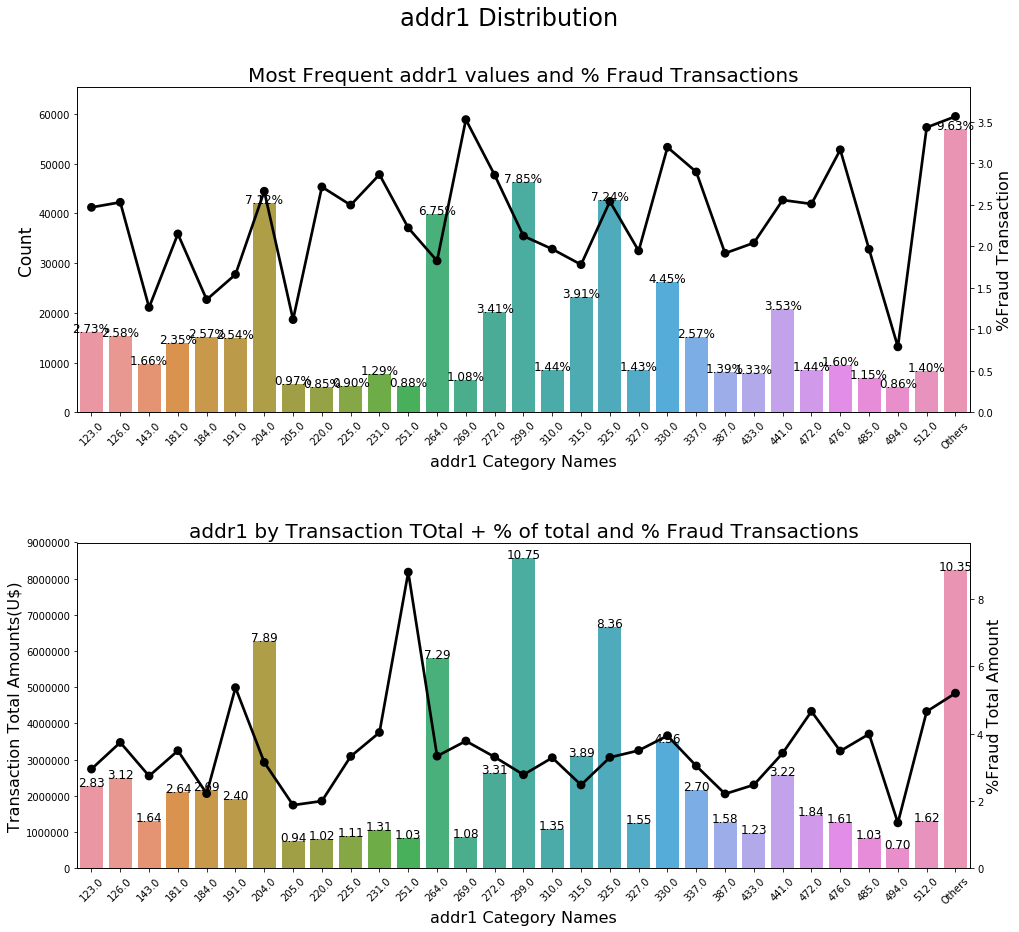

In [23]:
def ploting_cnt_amt(df, col, lim = 2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize = 'index')*100
    tmp = tmp.reset_index()
    tmp.rename(columns = {0: 'NoFraud', 1:'Fraud'}, inplace = True)
    
    plt.figure(figsize = (16,14))
    plt.suptitle(f'{col} Distribution', fontsize = 24)
    
    plt.subplot(211)
    g = sns.countplot(x =col, data = df, order = list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x = col, y = 'Fraud', data = tmp, order = list(tmp[col].values),
                      color = 'black', legend = False,)
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel('%Fraud Transaction',fontsize = 16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize = 20)
    g.set_xlabel(f"{col} Category Names", fontsize = 16)
    g.set_ylabel("Count",fontsize = 17)
    g.set_xticklabels(g.get_xticklabels(),rotation = 45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
              height +3,
              '{:1.2f}%'.format(height/total*100),
              ha = 'center',fontsize = 12)
    g.set_ylim(0,max(sizes)*1.15)
    
    ####################################################################
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
               / df.groupby([col])['TransactionAmt'].sum() *100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud',1:'Fraud'}, inplace = True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x = col, y = 'TransactionAmt', data = amt, order = list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x = col, y = 'Fraud', data = perc_amt, order = list(tmp[col].values),color = 'black', legend = False,)
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel('%Fraud Total Amount',fontsize = 16)
    g.set_xticklabels(g.get_xticklabels(), rotation = 45)
    g1.set_title(f"{col} by Transaction TOtal + % of total and % Fraud Transactions",fontsize = 20)
    g1.set_xlabel(f"{col} Category Names",fontsize = 16)
    g1.set_ylabel("Transaction Total Amounts(U$)",fontsize = 16)
    g1.set_xticklabels(g.get_xticklabels(),rotation = 45)
    
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x()+p.get_width()/2.,
               height + 3,
               '{:1.2f}'.format(height/total_amt*100),
               ha = "center",fontsize = 12)
        
    plt.subplots_adjust(hspace = .4, top = 0.9)
    plt.show()
    
ploting_cnt_amt(df_trans, 'addr1')
    

Addr1에서 흥미로운 패턴을 확인할 수 있습니다.

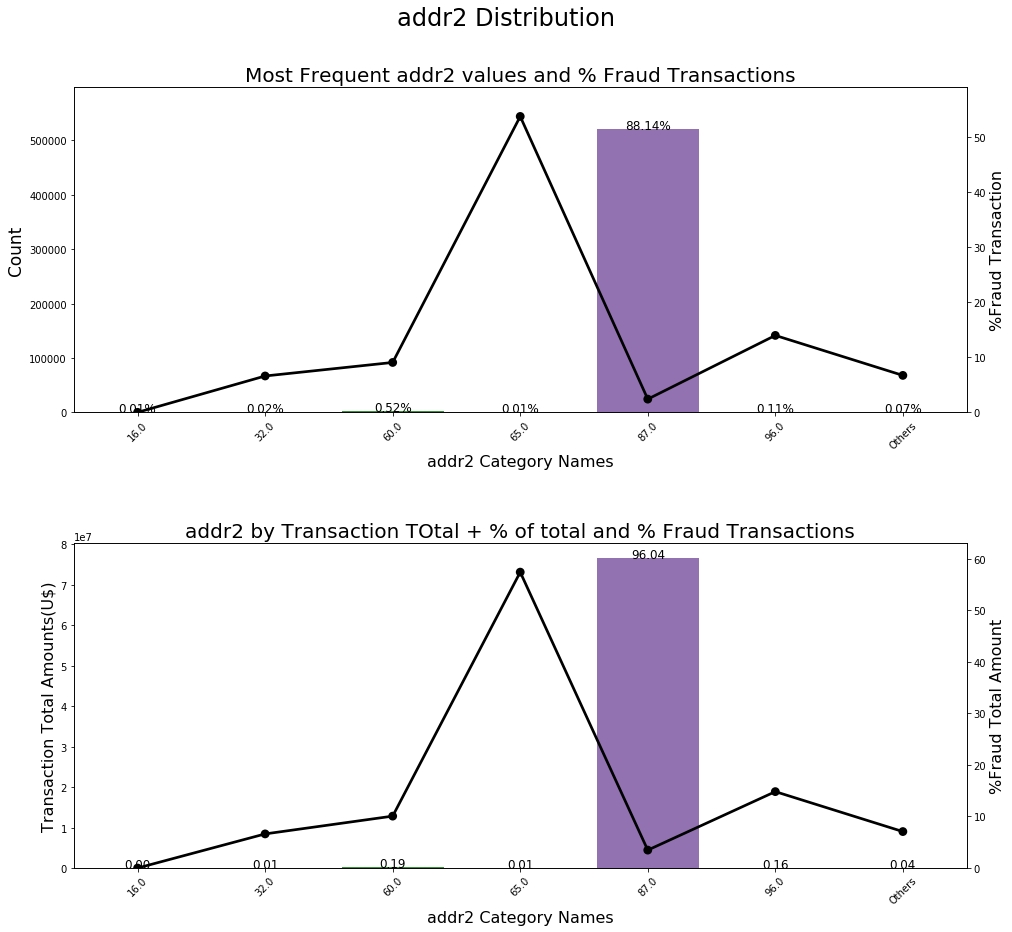

In [24]:
ploting_cnt_amt(df_trans,'addr2')

Addr2의 거의 모든 항목은 동일한 값을 갖습니다. 흥미롭게도 65에서 사기 비율은 60%에 육박합니다. 87이라는 항목이 총 항목의 88%을 차지하고 총 거래 금액의 96%를 차지하고 있습니다.

## P emaildomain Distributions
- 모든 이메일 도메인을 해당 기업별로 그룹화 할것입니다.
- 또한, 500 미만인 모든 값은 "Others"로 설정하겠습니다.

In [25]:
df_trans.loc[df_trans['P_emaildomain'].isin(['gmail.com','gmail']),'P_emaildomain'] = 'Google'

df_trans.loc[df_trans['P_emaildomain'].isin(['yahoo.com','yahoo.com.mx','yahoo.co.uk',
                                            'yahoo.co.jp','yahoo.de','yahoo.fr','yahho.es']),'P_emaildomain'] = 'Yahoo Mail'

df_trans.loc[df_trans['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com','love.com.mx',
                                            'hotmail.es','hotmail.co.uk','hotmail.de',
                                            'outlook.es','live.com','live.fr',
                                            'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
df_trans.loc[df_trans.P_emaildomain.isin(df_trans.P_emaildomain.value_counts()[df_trans.P_emaildomain.value_counts() <= 500].index),'P_emaildomain'] = 'Others'
df_trans.P_emaildomain.fillna("NoInf",inplace = True)

### Ploting P-Email Domain

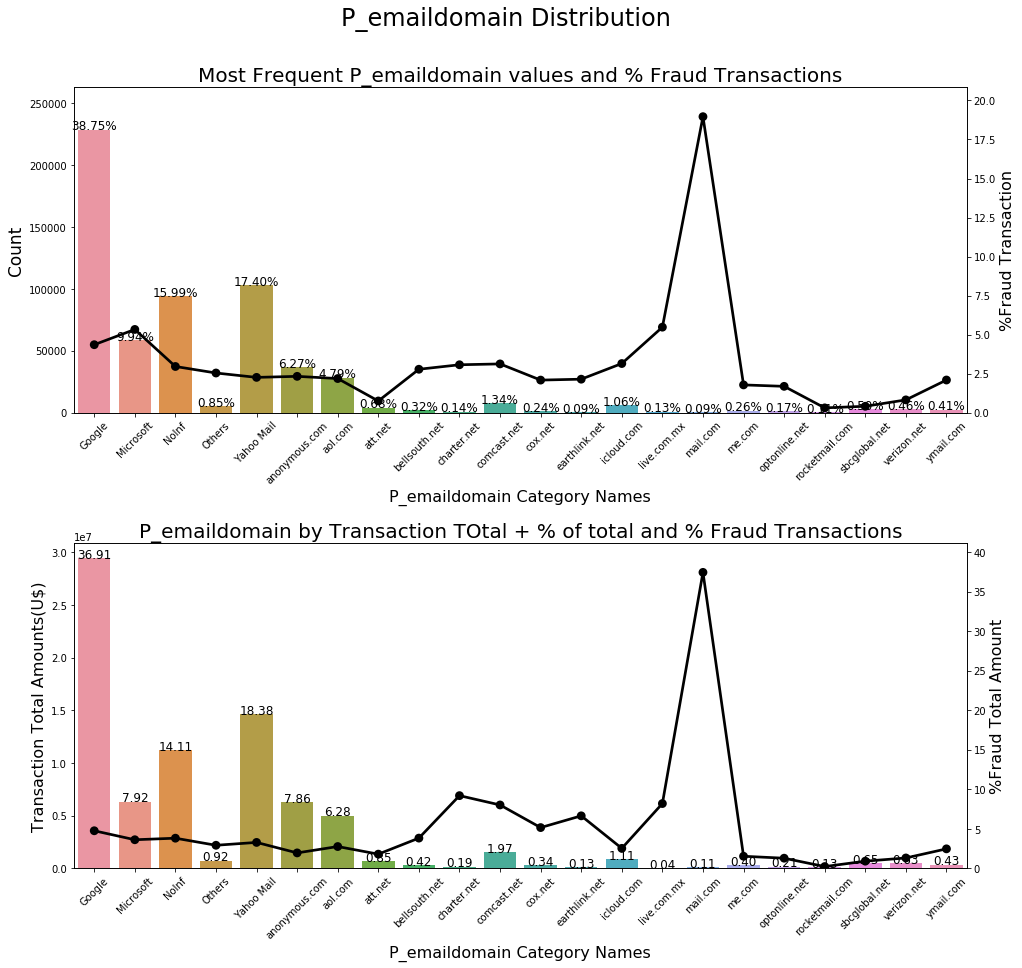

In [26]:
ploting_cnt_amt(df_trans,'P_emaildomain')

### R-Email Domaion plot distribution
- 모든 이메일 도메인을 해당 기업별로 그룹화 할것입니다.
- 또한, 300 미만인 모든 값은 "Others"로 설정하겠습니다.

In [27]:
df_trans.loc[df_trans['R_emaildomain'].isin(['gmail.com','gmail']),'R_emaildomain'] = 'Google'

df_trans.loc[df_trans['R_emaildomain'].isin(['yahoo.com','yahoo.com.mx','yahoo.co.uk',
                                            'yahoo.co.jp','yahoo.de','yahoo.fr','yahoo.co.jp',
                                            'yahoo.es']),"R_emaildomain"] = 'Yahoo Mail'
df_trans.loc[df_trans['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com','live.com.mx',
                                            'hotmail.es','hotmail.co.uk','hotmail.de','outlook.es',
                                            'live.com','live.fr','hotmail.fr']),'R_emaildomain'] = 'Microsoft'
df_trans.loc[df_trans.R_emaildomain.isin(df_trans.R_emaildomain.value_counts()[df_trans.R_emaildomain.value_counts() <= 300].index),'R_emaildomain'] = 'Others'
df_trans.R_emaildomain.fillna("NoInf",inplace=True)

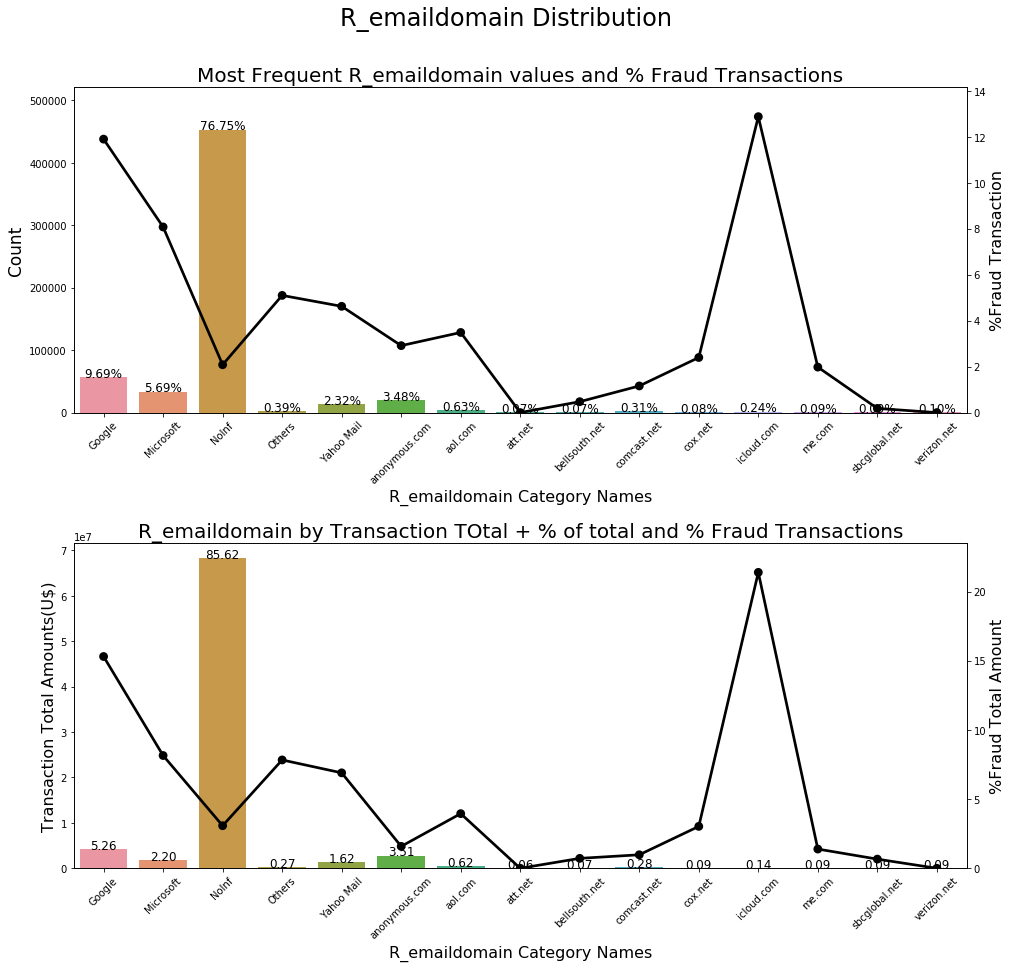

In [28]:
ploting_cnt_amt(df_trans,'R_emaildomain')

두 이메일 도메인 특성은 매우 비슷한 분포를 보이고 있다는 것을 알 수 있다.  
구글과 아이클라우드에서 매우 높은 사기 거래를 보였다.

## C1-C14 Features
- 이 변수들에 대하여 이해 해보자.
- 어떤 분포를 보이는가?

In [29]:
resumetable(df_trans[['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10',
                     'C11','C12','C13','C14']])

Dataset Shape: (590540, 14)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,C1,float16,0,1495,1.0,1.0,1.0,2.72
1,C2,float16,0,1167,1.0,1.0,1.0,2.75
2,C3,float16,0,27,0.0,0.0,0.0,0.04
3,C4,float16,0,1223,0.0,0.0,0.0,1.12
4,C5,float16,0,319,0.0,0.0,0.0,2.06
5,C6,float16,0,1291,1.0,1.0,1.0,2.52
6,C7,float16,0,1069,0.0,0.0,0.0,0.71
7,C8,float16,0,1130,0.0,0.0,0.0,1.25
8,C9,float16,0,205,1.0,0.0,1.0,2.62
9,C10,float16,0,1122,0.0,0.0,0.0,1.23


In [30]:
df_trans[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']].describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,590540.0,590540.0,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0
mean,NaN,NaN,0.005650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.150635,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
min,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
50%,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0
75%,3.0,3.0,0.000000,0.0,1.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,12.0,2.0
max,4684.0,5692.0,26.000000,2252.0,349.0,2252.0,2256.0,3332.0,210.0,3256.0,3188.0,3188.0,2918.0,1429.0


In [31]:
df_trans.loc[df_trans.C1.isin(df_trans.C1.value_counts()[df_trans.C1.value_counts() <= 400].index),'C1'] = 'Others'

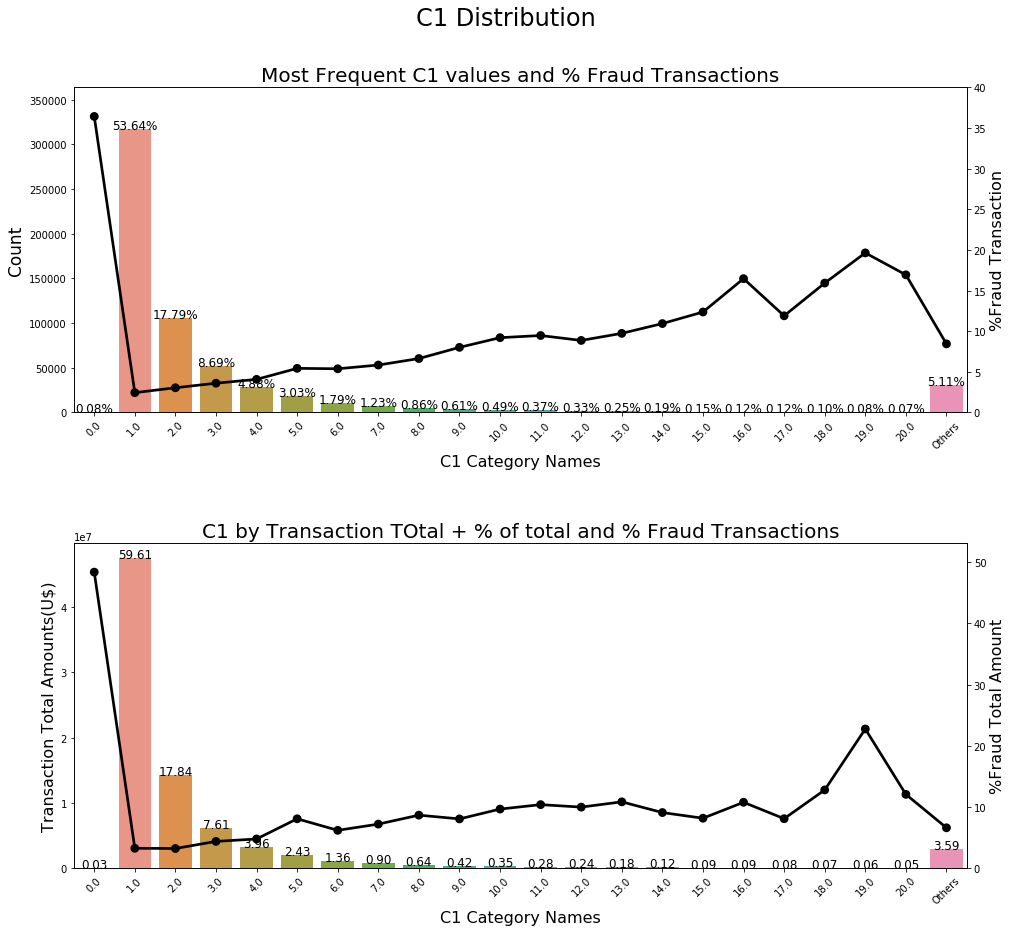

In [32]:
ploting_cnt_amt(df_trans,'C1')

In [33]:
df_trans.loc[df_trans.C2.isin(df_trans.C2.value_counts()[df_trans.C2.value_counts() <= 350].index),'C2'] = 'Others'

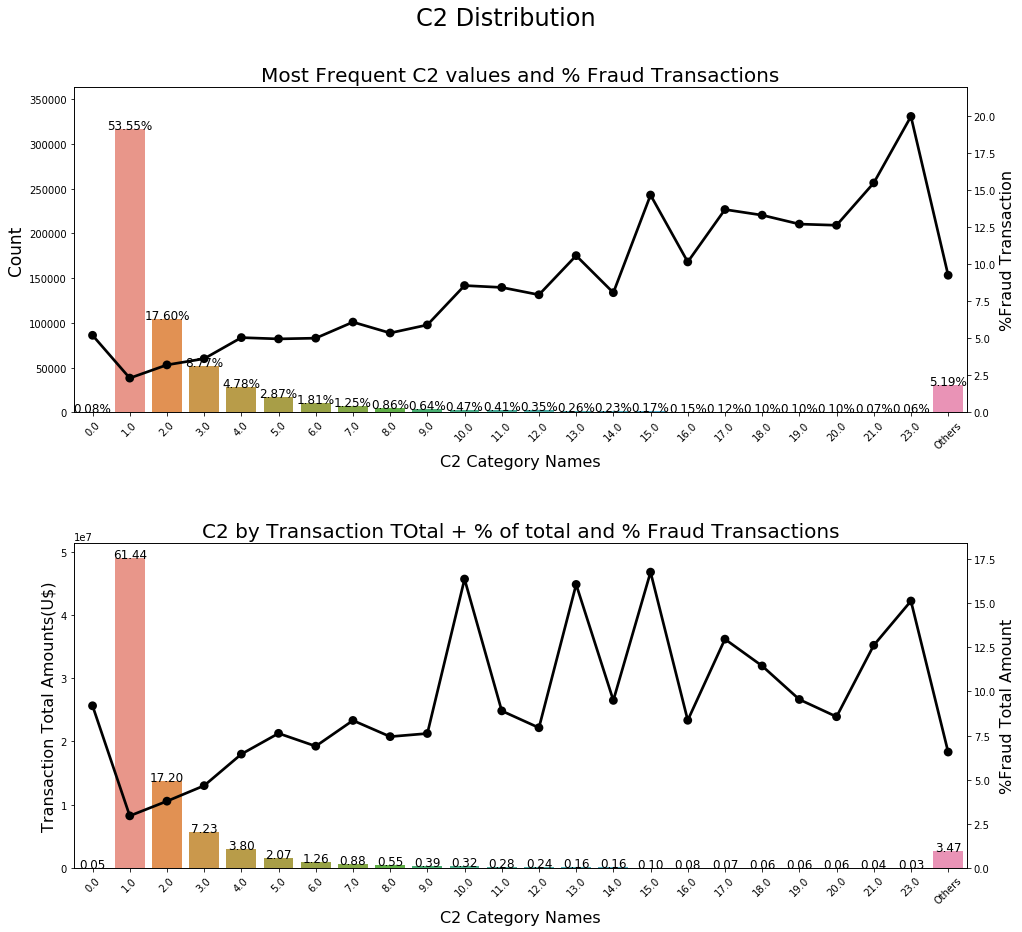

In [34]:
ploting_cnt_amt(df_trans,'C2')

상위 3 개의 값은 1, 2 및 3이며 총 금액에서 동일합니다.  
또한, 사기 비율에서 똑같은 패턴을 보인다는 것을 알 수 있습니다.

## TimeDelta Feature
- 이제, 사기 거래가 주로 발생한 시간대가 언제이고, 언제 가장 높은 사기거래가 발생 했는지 알아보겠습니다.

### Converting to Total Days, Weekdays and Hours
Discussion 탭에서 Timedelta 컬럼에 대한 완벽한 해결책을 찾았으며, 아래에 링크를 남겨둡니다.  
첫 날을 2017-12-01로 두고, delta time을 사용하여 datetime 특성을 계산합니다.

In [35]:
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100400#latest-579480
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE,'%Y-%m-%d')
df_trans['Date'] = df_trans['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

df_trans['_Weekdays'] = df_trans['Date'].dt.dayofweek
df_trans['_Hours'] = df_trans['Date'].dt.hour
df_trans['_Days'] = df_trans['Date'].dt.day

### Top Days with highest Total Transaction Amount

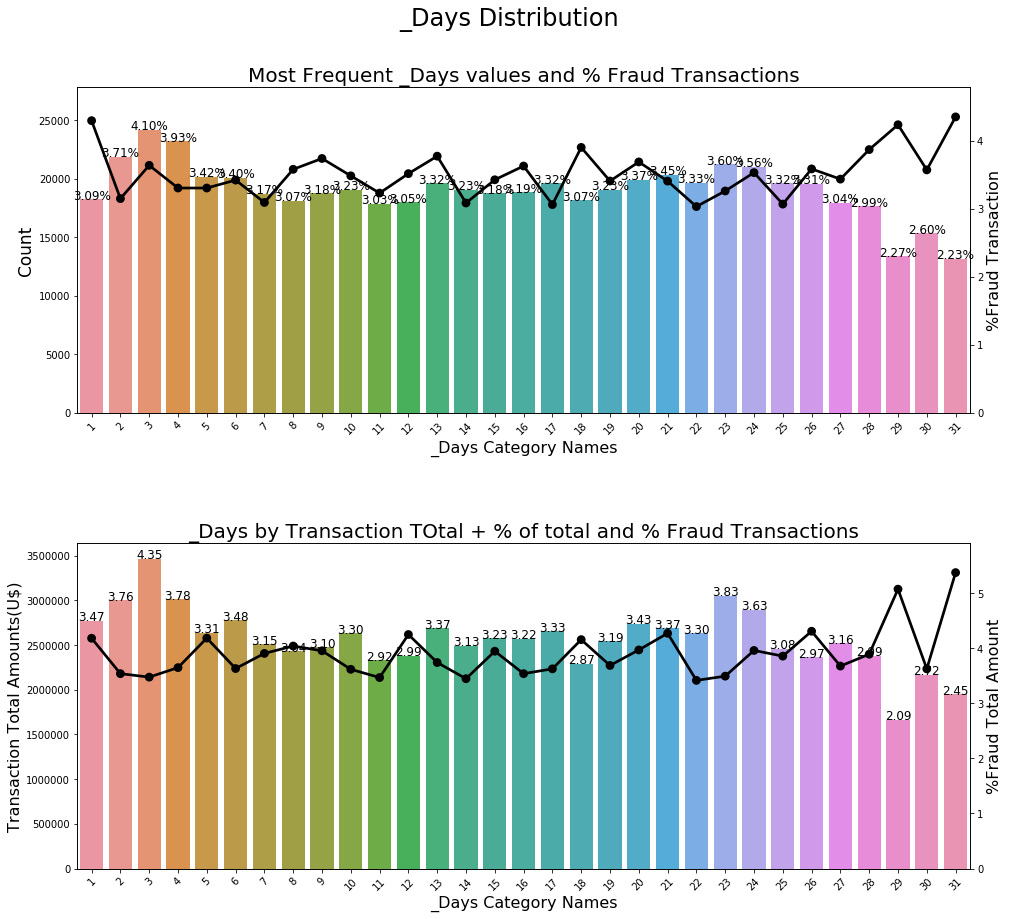

In [36]:
ploting_cnt_amt(df_trans,'_Days')

### Ploting WeekDays Distributions

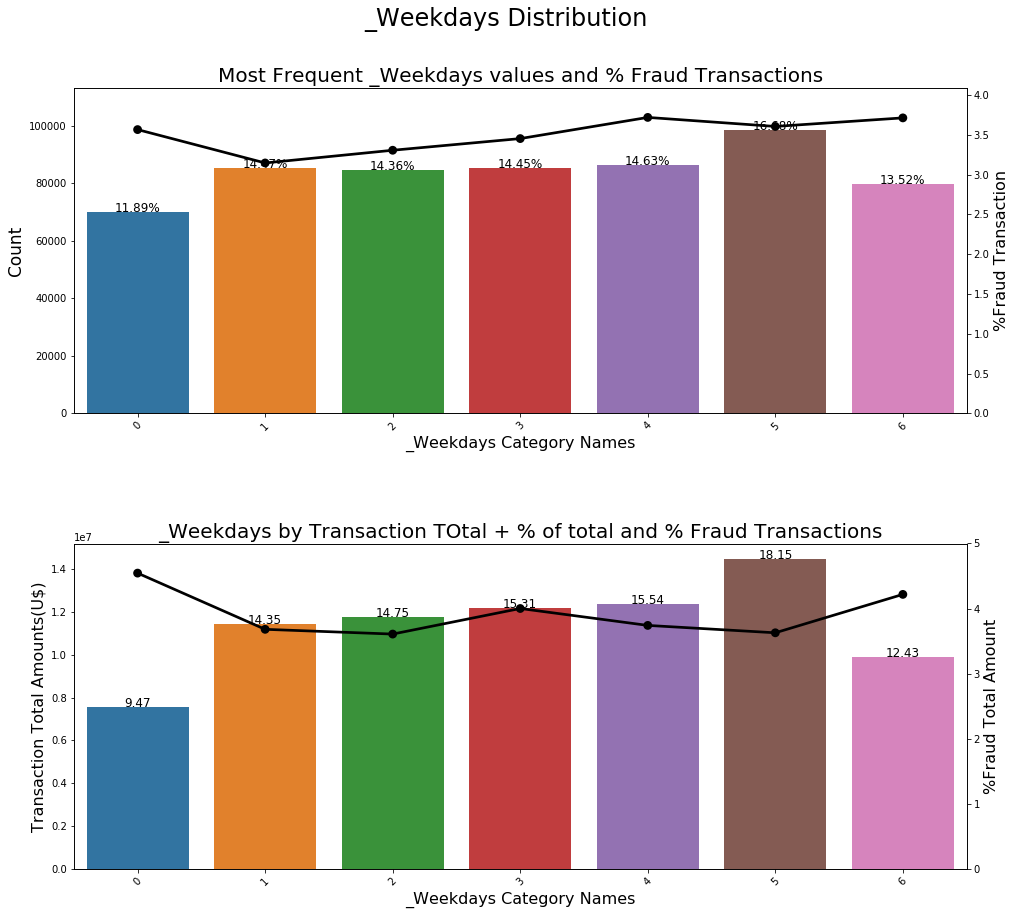

In [37]:
ploting_cnt_amt(df_trans,'_Weekdays')

날짜에 대한 참고는 없지만, 0과 6일에 거래가 상대적으로 적다는 것을 알 수 있습니다. 이를 통해 이 두 날짜는 주말이라는 것을 유추할 수 있습니다.

### Ploting Hours Distributions

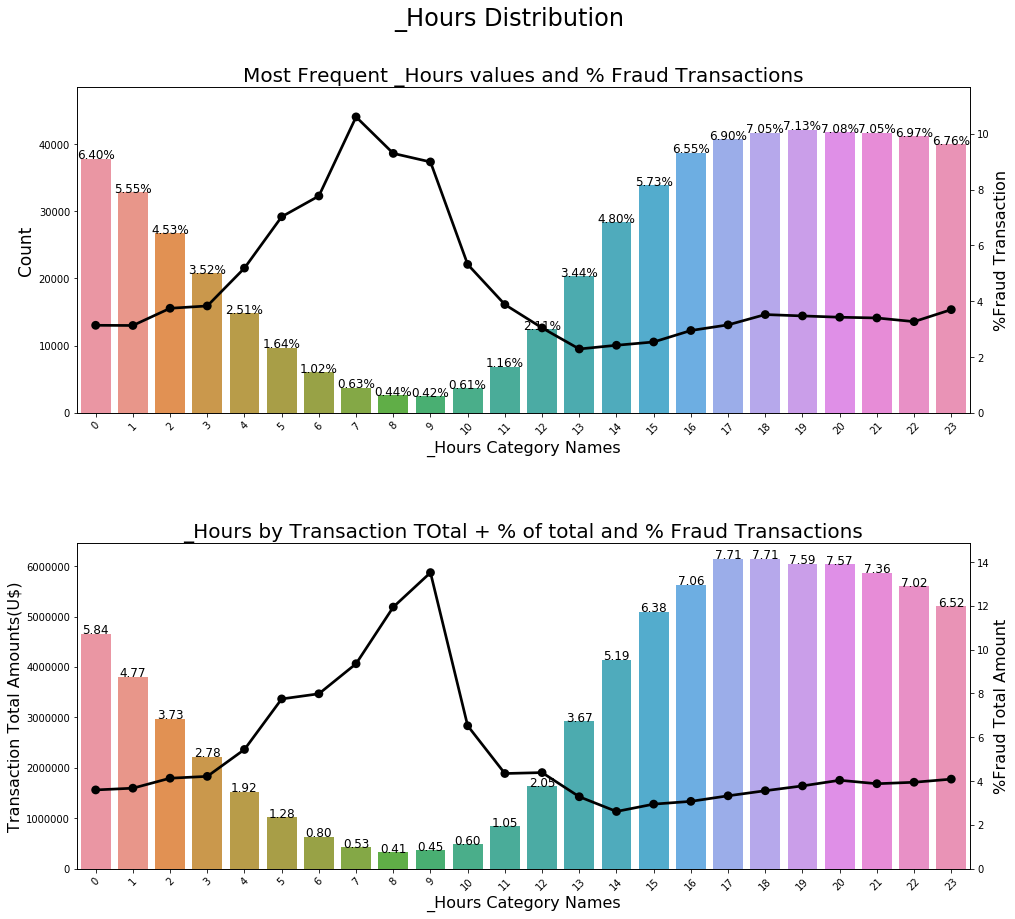

In [38]:
ploting_cnt_amt(df_trans,'_Hours')

### Transactions and Total Amount by each day

In [39]:
#seting some static color options
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']

dates_temp = df_trans.groupby(df_trans.Date.dt.date)['TransactionAmt'].count().reset_index()

trace = go.Scatter(x = dates_temp['Date'], y = dates_temp.TransactionAmt,
                  opacity = .8, line = dict(color = color_op[7]), name = 'Total_ Transaction')

dates_temp_sum = df_trans.groupby(df_trans.Date.dt.date)['TransactionAmt'].sum().reset_index()

trace1 = go.Scatter(x = dates_temp_sum.Date, line = dict(color = color_op[1]), name = 'Total Amount',
                  y = dates_temp['TransactionAmt'], opacity = .8, yaxis  = 'y2')

layout = dict(
    title= "Total Transactions and Fraud Informations by Date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date' ),
    yaxis=dict(title='Total Transactions'),
    yaxis2=dict(overlaying='y',
                anchor='x', side='right',
                zeroline=False, showgrid=False,
                title='Total Transaction Amount')
)

# Creating figure with the both traces and layout
fig = dict(data = [trace, trace1,], layout = layout)

#rendering the graphs
iplot(fig)

## FRAUD TRANSACTIONS BY DATE
- 날짜별 사기 거래 시각화

In [40]:
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']

tmp_amt = df_trans.groupby([df_trans.Date.dt.date, 'isFraud'])['TransactionAmt'].sum().reset_index()
tmp_trans = df_trans.groupby([df_trans.Date.dt.date, 'isFraud'])['TransactionAmt'].count().reset_index()

tmp_trans_fraud = tmp_trans[tmp_trans['isFraud'] == 1]
tmp_amt_fraud = tmp_amt[tmp_amt['isFraud'] == 1]

dates_temp = df_trans.groupby(df_trans.Date.dt.date)['TransactionAmt'].count().reset_index()

trace = go.Scatter(x = tmp_trans_fraud['Date'], y = tmp_trans_fraud.TransactionAmt,
                  opacity = .8, line = dict(color = color_op[1]), name = 'Fraud Transactions')

trace1 = go.Scatter(x = tmp_amt_fraud.Date, line = dict(color = color_op[7]),
                                                       name = 'Fraud Amount', y = tmp_amt_fraud['TransactionAmt'],
                   opacity = .8, yaxis = 'y2')

layout = dict(
    title= "FRAUD TRANSACTIONS - Total Transactions and Fraud Informations by Date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date' ),
    yaxis=dict(title='Total Transactions'),
    yaxis2=dict(overlaying='y',
                anchor='x', side='right',
                zeroline=False, showgrid=False,
                title='Total Transaction Amount')
)

fig = dict(data = [trace, trace1], layout = layout)

iplot(fig)

## Features [id_12 to id_38]
- 훈련 Identity Dataset 내의 카테고리 특성 확인

In [41]:
df_id[['id_12','id_13','id_14','id_15','id_16','id_17','id_18','id_19',
      'id_20','id_21','id_22','id_23','id_24','id_25','id_26','id_28','id_29','id_30',
      'id_31','id_32','id_33','id_34','id_35','id_36','id_37','id_38']].describe(include = 'all')

,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
count,144233,127320.0,80044.0,140985,129340,139369.0,4.511300e+04,139318.0,139261.0,5159.0,...,140978,77565,140282,77586.0,73289,77805,140985,140985,140985,140985
unique,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN,...,2,75,130,NaN,260,4,2,2,2,2
top,NotFound,NaN,NaN,Found,Found,NaN,NaN,NaN,NaN,NaN,...,Found,Windows 10,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F
freq,123025,NaN,NaN,67728,66324,NaN,NaN,NaN,NaN,NaN,...,74926,21155,22000,NaN,16874,60011,77814,134066,110452,73922
mean,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN,inf,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.0,NaN,NaN,NaN,0.0,1.561523e+00,NaN,NaN,inf,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,10.0,-660.0,NaN,NaN,100.0,1.000000e+01,100.0,100.0,100.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,49.0,-360.0,NaN,NaN,166.0,1.300000e+01,266.0,256.0,252.0,...,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,52.0,-300.0,NaN,NaN,166.0,1.500000e+01,341.0,472.0,252.0,...,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,52.0,-300.0,NaN,NaN,225.0,1.500000e+01,427.0,533.0,486.5,...,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
df_train = df_trans.merge(df_id, how = 'left', left_index = True, right_index = True)

### Ploting columns with few unique values

In [43]:
def cat_feat_ploting(df,col):
    tmp = pd.crosstab(df[col],df['isFraud'], normalize = 'index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns = {0:'NoFraud',1:'Fraud'}, inplace = True)
    
    plt.figure(figsize = (14,10))
    plt.suptitle(f'{col} Distribution', fontsize = 22)
    
    plt.subplot(221)
    g = sns.countplot(x = col, data = df, order = tmp[col].values)
    
    g.set_title(f"{col} Distribution", fontsize = 19)
    g.set_xlabel(f"{col} Name", fontsize = 17)
    g.set_ylabel("Count", fontsize = 17)
    
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
              height + 3,
              '{:1.2f}%'.format(height/total*100),
              ha = 'center', fontsize = 14)
    
    plt.subplot(222)
    g1 = sns.countplot(x = col, hue = 'isFraud', data = df, order = tmp[col].values)
    plt.legend(title = 'Fraud', loc = 'best', labels = ['No','Yes'])
    gt = g1.twinx()
    gt = sns.pointplot(x = col, y = 'Fraud', data = tmp, color = 'black', order = tmp[col].values,
                      legend = False)
    gt.set_ylabel("% of Fraud Transactions", fontsize = 16)
    
    g1.set_title(f"{col} by Target(isFraud)", fontsize = 19)
    g1.set_xlabel(f"{col} Name", fontsize = 17)
    g1.set_ylabel("Count", fontsize = 17)
    
    plt.subplot(212)
    g3 = sns.boxenplot(x = col, y = 'TransactionAmt', hue = 'isFraud',
                      data = df[df['TransactionAmt'] <= 2000], order = tmp[col].values)
    g3.set_xlabel("ProductCD Name", fontsize = 17)
    g3.set_ylabel("Transaction Values", fontsize = 17)
    
    plt.subplots_adjust(hspace = 0.4, top = 0.85)
    
    plt.show()

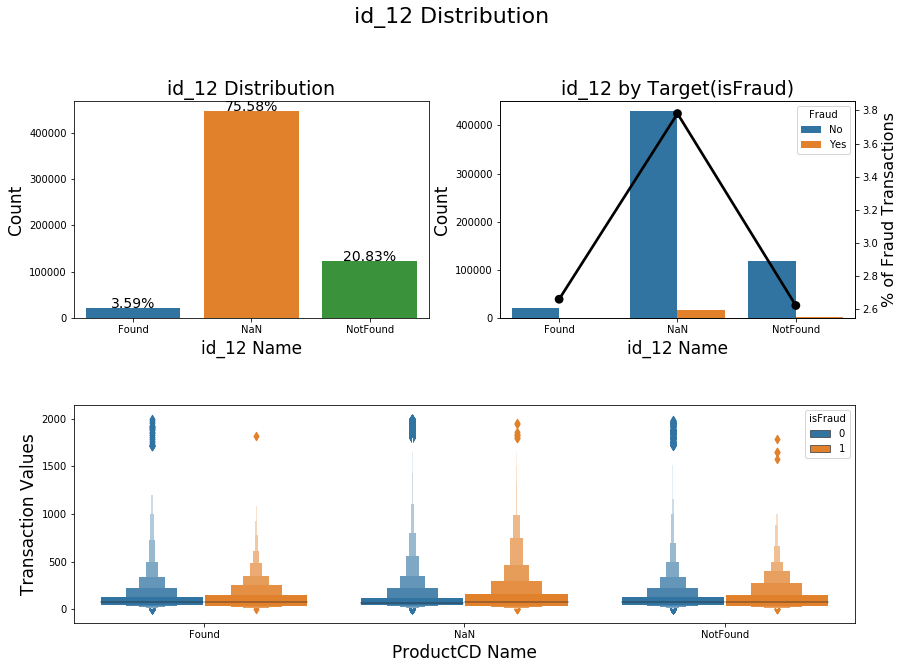

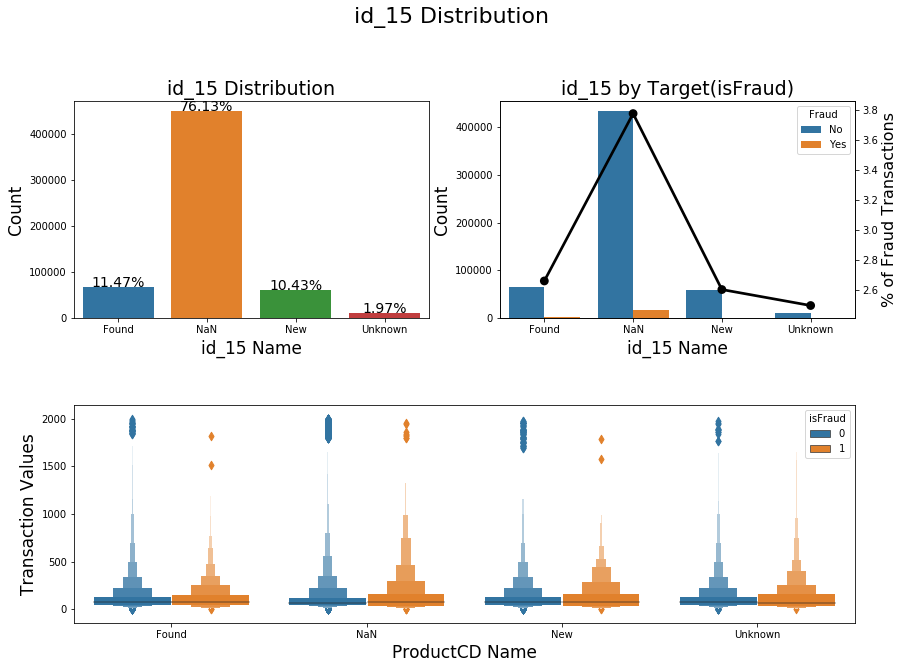

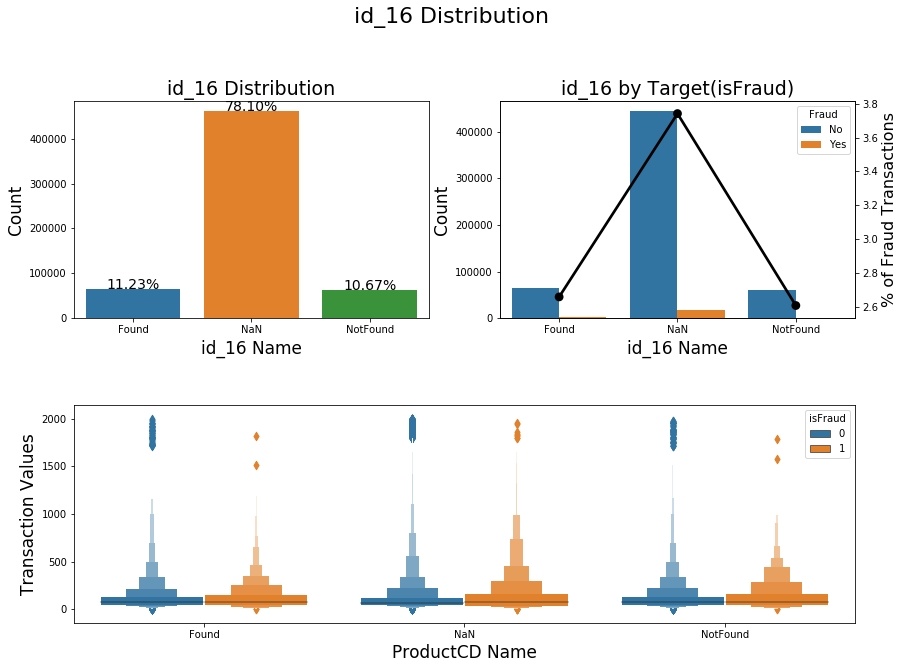

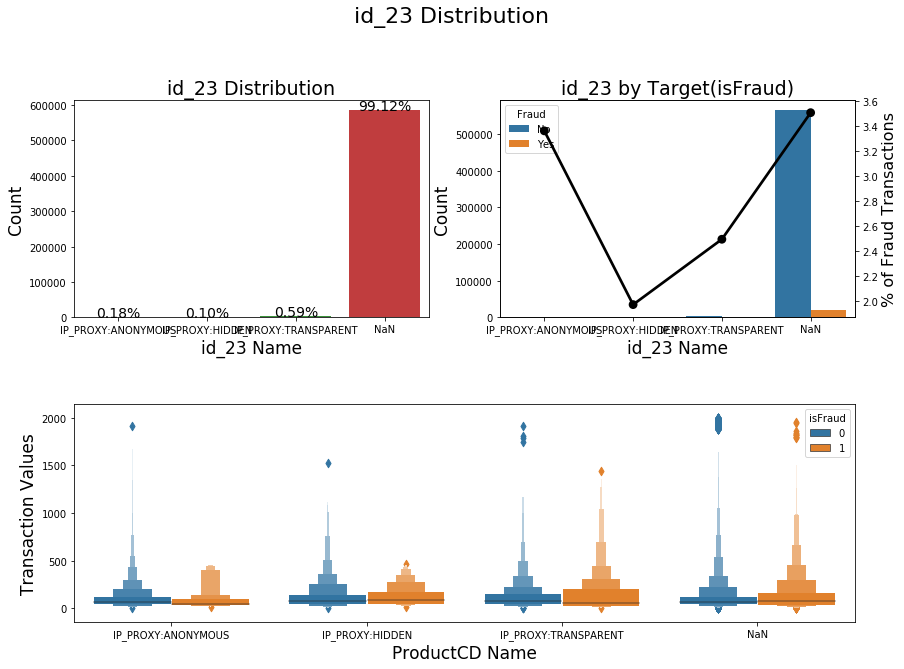

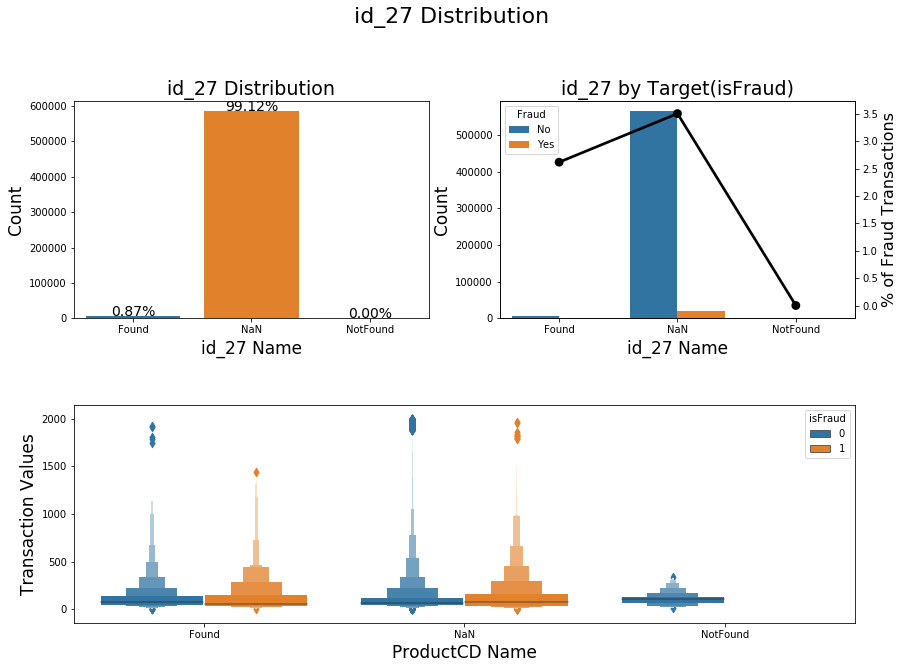

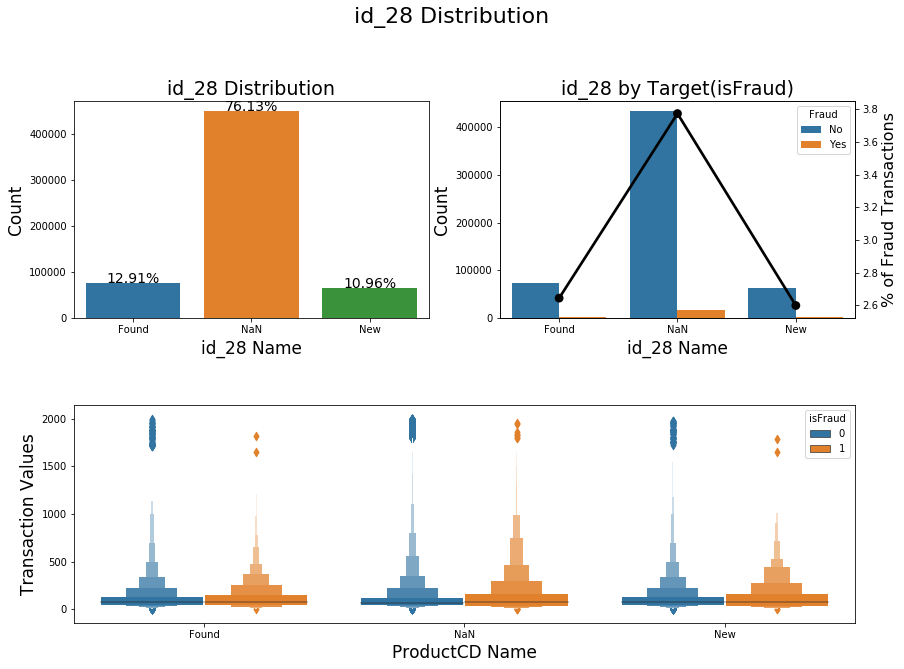

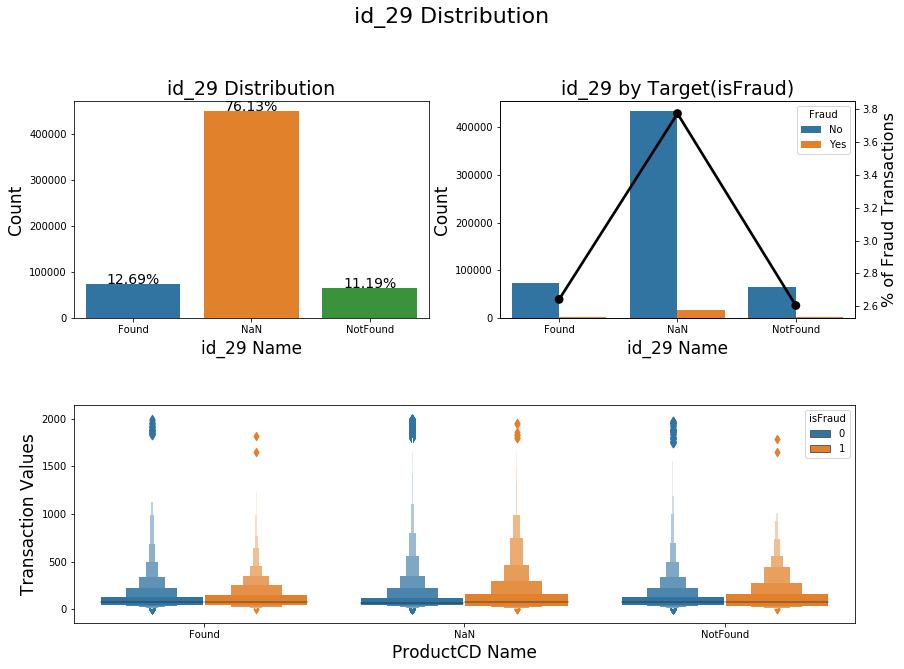

In [44]:
for col in ['id_12','id_15','id_16','id_23','id_27','id_28','id_29']:
    df_train[col] = df_train[col].fillna('NaN')
    cat_feat_ploting(df_train, col)

### Id 30

In [45]:
df_train.loc[df_train['id_30'].str.contains('Windows', na = False), 'id_30'] = 'Windows'
df_train.loc[df_train['id_30'].str.contains('iOS',na = False),'id_30'] = 'iOS'
df_train.loc[df_train['id_30'].str.contains('Mac OS',na = False), 'id_30'] = 'Mac'
df_train.loc[df_train['id_30'].str.contains('Android',na = False), 'id_30'] = 'Android'
df_train['id_30'].fillna('NAN',inplace = True)

### Id 31

In [46]:
df_train.loc[df_train['id_31'].str.contains('chrome', na = False),'id_31'] = 'Chrome'
df_train.loc[df_train['id_31'].str.contains('firefox',na = False),'id_31'] = 'Firefox'
df_train.loc[df_train['id_31'].str.contains('safari', na = False), 'id_31'] = 'Safari'
df_train.loc[df_train['id_31'].str.contains('edge', na = False),'id_31'] = 'Edge'
df_train.loc[df_train['id_31'].str.contains('ie', na = False),'id_31'] = 'IE'
df_train.loc[df_train['id_31'].str.contains('samsung',na = False),'id_31'] = 'Samsung'
df_train.loc[df_train['id_31'].str.contains('opera', na = False),'id_31'] = 'Opera'
df_train['id_31'].fillna('NAN',inplace = True)
df_train.loc[df_train.id_31.isin(df_train.id_31.value_counts()[df_train.id_31.value_counts() < 200].index),'id_31'] = 'Others'

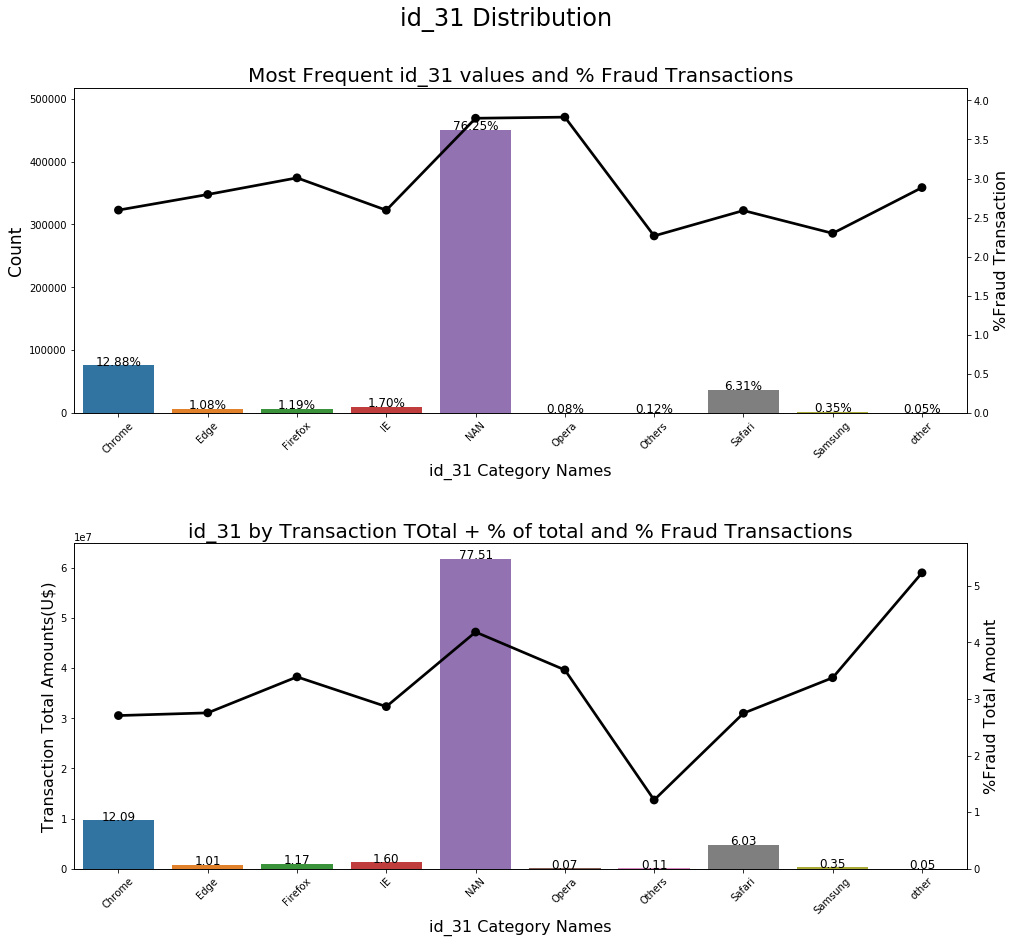

In [47]:
ploting_cnt_amt(df_train,'id_31')

## Modelling
보다 쉽게 시작하기 위해서, 다음 커널을 이용 및 참고하여 모델링을 시작해 보겠습니다.  
https://www.kaggle.com/artkulak/ieee-fraud-simple-baseline-0-9383-lb - (@artkulak - Art)  
https://www.kaggle.com/artgor/eda-and-models - (@artgor - Andrew Lukyanenko)

In [48]:
df_trans = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv')
df_test_trans = pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv')

df_id = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv')
df_test_id = pd.read_csv('../input/ieee-fraud-detection/test_identity.csv')

sample_submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv',index_col = 'TransactionID')

df_train = df_trans.merge(df_id, how = 'left', left_index = True, right_index = True,
                         on = 'TransactionID')
df_test = df_test_trans.merge(df_test_id, how = 'left', left_index = True, right_index = True,
                             on = 'TransactionID')

print("Train Dataset Shape:",df_train.shape)
print("Test Dataset Shape:", df_test.shape)

del df_trans, df_id, df_test_trans, df_test_id

Train Dataset Shape: (590540, 434)
Test Dataset Shape: (506691, 433)


In [49]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 645.97 Mb (67.0% reduction)
Mem. usage decreased to 561.50 Mb (66.5% reduction)


### Mapping emails

In [50]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest-579654
for c in ['P_emaildomain','R_emaildomain']:
    df_train[c + '_bin'] = df_train[c].map(emails)
    df_test[c + '_bin'] = df_test[c].map(emails)
    
    df_train[c + '_suffix'] = df_train[c].map(lambda x:str(x).split('.')[-1])
    df_test[c + '_suffix'] = df_test[c].map(lambda x:str(x).split('.')[-1])
    
    df_train[c + '_suffix'] = df_train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    df_test[c + '_suffix'] = df_test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

### Encoding categorical features 

In [51]:
# Lable Encoding
for f in df_train.drop('isFraud',axis = 1).columns:
    if df_train[f].dtype == 'object' or df_test[f].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_train[f].values) + list(df_test[f].values))
        df_train[f] = lbl.transform(list(df_train[f].values))
        df_test[f] = lbl.transform(list(df_test[f].values))

### Some feature engineering

In [52]:
df_train['Trans_min_mean'] = df_train['TransactionAmt'] - df_train['TransactionAmt'].mean()
df_train['Trans_min_std'] = df_train['Trans_min_mean'] / df_train['TransactionAmt'].std()
df_test['Trans_min_mean'] = df_test['TransactionAmt'] - df_test['TransactionAmt'].mean()
df_test['Trans_min_std'] = df_test['Trans_min_mean'] / df_test['TransactionAmt'].std()

In [53]:
df_train['TransactionAmt_to_mean_card1'] = df_train['TransactionAmt'] / df_train.groupby(['card1'])['TransactionAmt'].transform('mean')
df_train['TransactionAmt_to_mean_card4'] = df_train['TransactionAmt'] / df_train.groupby(['card4'])['TransactionAmt'].transform('mean')
df_train['TransactionAmt_to_std_card1'] = df_train['TransactionAmt'] / df_train.groupby(['card1'])['TransactionAmt'].transform('std')
df_train['TransactionAmt_to_std_card4'] = df_train['TransactionAmt'] / df_train.groupby(['card4'])['TransactionAmt'].transform('std')

df_test['TransactionAmt_to_mean_card1'] = df_test['TransactionAmt'] / df_test.groupby(['card1'])['TransactionAmt'].transform('mean')
df_test['TransactionAmt_to_mean_card4'] = df_test['TransactionAmt'] / df_test.groupby(['card4'])['TransactionAmt'].transform('mean')
df_test['TransactionAmt_to_std_card1'] = df_test['TransactionAmt'] / df_test.groupby(['card1'])['TransactionAmt'].transform('std')
df_test['TransactionAmt_to_std_card4'] = df_test['TransactionAmt'] / df_test.groupby(['card4'])['TransactionAmt'].transform('std')

In [54]:
df_train['TransactionAmt'] = np.log(df_train['TransactionAmt'])
df_test['TransactionAmt'] = np.log(df_test['TransactionAmt'])

### Concating DataFrames to get PCA of V feature

In [55]:
df_test['isFraud'] = 'test'
df = pd.concat([df_train, df_test], axis = 0, sort = False)
df = df.reset_index()
df = df.drop('index',axis = 1)

In [56]:
def PCA_change(df, cols, n_components, prefix = 'PCA_', rand_seed = 42):
    pca = PCA(n_components = n_components, random_state = rand_seed)
    
    principalComponents = pca.fit_transform(df[cols])
    
    principalDf = pd.DataFrame(principalComponents)
    
    df.drop(cols, axis = 1, inplace = True)
    
    principalDf.rename(columns = lambda x: str(prefix) + str(x), inplace = True)
    
    df = pd.concat([df, principalDf], axis = 1)
    
    return df

In [57]:
mas_v = df_train.columns[55:394]

### Getting PCA

In [58]:
for col in mas_v:
    df[col] = df[col].fillna((df[col].min() - 2))
    df[col] = (minmax_scale(df[col],feature_range = (0,1)))
    
    
df = PCA_change(df, mas_v,prefix = 'PCA_V_',n_components = 30)

In [59]:
df = reduce_mem_usage(df)

Mem. usage decreased to 280.44 Mb (60.1% reduction)


### Seting train test back

In [60]:
df_train, df_test = df[df['isFraud'] != 'test'], df[df['isFraud'] == 'test'].drop('isFraud',axis = 1)

In [61]:
print('Train DataFrame Shape:',df_train.shape)

Train DataFrame Shape: (590540, 135)


### Setting X and Y

In [62]:
X_train = df_train.sort_values('TransactionDT').drop(['isFraud','TransactionDT'],axis = 1)
y_train = df_train.sort_values('TransactionDT')['isFraud'].astype(bool)

X_test = df_test.sort_values('TransactionDT').drop(['TransactionDT'], axis =1)

del df_train
df_test = df_test[['TransactionDT']]

### Defining the HyperOpt function with parameters space and model

In [63]:
def objective(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma' : "{:.3f}".format(params['gamma']),
        'subsample' : "{:.2f}".format(params['subsample']),
        'reg_alpha' : "{:.3f}".format(params['reg_alpha']),
        'learning_rate' : "{:.3f}".format(params['learning_rate']),
        'num_leaves' : "{:.3f}".format(params['num_leaves']),
        'colsample_bytree' : "{:.3f}".format(params['colsample_bytree']),
        'min_child_samples' : "{:.3f}".format(params['min_child_samples']),
        'feature_fraction' : "{:.3f}".format(params['feature_fraction']),
        'bagging_fraction' : "{:.3f}".format(params['bagging_fraction'])
    }
    
    print("#################### New Run #####################")
    print(f"params = {params}")
    FOLDS = 5
    count = 1
    skf = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = 42)
    
    tss = TimeSeriesSplit(n_splits = FOLDS)
    y_preds = np.zeros(sample_submission.shape[0])
    score_mean = 0
    for tr_idx, val_idx in tss.split(X_train, y_train):
        clf = xgb.XGBClassifier(n_estimators = 600, random_state = 42, verbose = True,
                               tree_method = 'gpu_hist',
                               **params)
        
        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr,y_tr)
        
        score = make_scorer(roc_auc_score, needs_proba = True)(clf, X_vl, y_vl)
        
        score_mean += score
        print(f'{count} CV - score: {round(score,4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2/60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)

space = {
    # 트리의 최대 깊이, GBM과 같습니다.
    # 과대적합을 제어하기 위해 사용, 높은 깊이는 과대적합될 수 있습니다.
    # 특정 샘플에 대한 관계를 학습시킵니다.
    # Cross Validation을 사용하여 튜닝해야 합니다.
    # 일반적인 값: 3 - 10
    'max_depth' : hp.quniform('max_depth', 7, 23, 1),
    
    # reg_alpha: L1 규제 파라미터. L1 규제는 희소성을 상승시킵니다.
    # (meaning pulling weights to 0). objective가 Logistic Regression일 때, 
    # Feature Selection에 유용할 수 있습니다.
    'reg_alpha' : hp.uniform('reg_alpha', 0.01, 0.4),
    
    # reg_lambda: L2 규제 파라미터. 더 작은 가중치를 부여하길 권장합니다.
    # 이 접근 방식은 Zeroing Feature(?)가 의미가 없을 수 있는 트리 모델에서 더 유용할 수 있습니다.
    'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),
    
    # eta: GBM의 학습률과 유사하게 각 단계의 가중치를 줄임으로써 모델을 더욱 견고하게 합니다.
    # 일반적인 값: 0.01 - 0.2
    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2),
    
    # colsample_bytree: GBM에서 max_feature와 비슷합니다. 
    # 각 트리에 대해 무작위로 추출할 Feature의 비율입니다.
    # 일반적인 값: 0.5 - 1
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.3, .9),
    
    # 노드는 분할 결과가 손실 함수를 양수로 감소시킬 때만 분할됩니다. 
    # gamma: 분할에 필요한 최소 loss 감소를 명시합니다. 또한 알고리즘을 보수적으로 만듭니다.
    # 이 값은 손실 함수에 따라 달라질 수 있으므로 조정이 필요합니다.
    'gamma' : hp.uniform('gamma', 0.01, .7),
    
    # 정확도를 더 올려주지만, 모델이 과적합될 수 있습니다.
    # num_leaves: 사용할 리프 노드 수.
    # leaf가 많으면 정확도가 향상되지만 과적합도 발생합니다.
    'num_leaves' : hp.choice('num_leaves', list(range(20,250,10))),
    
    # 리프 노드 당 최소 표본의 수를 지정합니다.
    # leaf으로 그룹화할 최소 표본의 수
    # 이 매개변수는 과대적합에 크게 도움 될 수 있습니다. leaf당 표본의 크기가 클수록 
    # 과적합에서 벗어날 수 있습니다. 반대로 생각하면, 오히려 과소적합으로 이어질 수 있습니다.
    'min_child_samples' : hp.choice('min_child_samples', list(range(100, 250, 10))),
    
    # subsample: 각 하위 트리를 생성할 때, 고려해야 할 관측값의 일부를 나타냅니다.
    'subsample' : hp.choice('subsample', [.2,.4,.5,.6,.7,.8,.9]),
    
    # Feature의 일부를 무작위로 선택합니다.
    # feature_fraction: 훈련에 사용되는 Feature의 subsampling을 제어합니다.
    # 배깅의 경우 실제 훈련 데이터에서 subsampling하는 것과는 대조적입니다.
    # 작을수록 과적합이 줄어듭니다.
    'feature_fraction' : hp.uniform('feature_fraction',.4, .8),
    
    # 무작위로 훈련 데이터를 넣거나, 샘플링합니다.
    'bagging_fraction' : hp.uniform('bagging_fraction', .4, .9),
    
    # bagging_fraction & bagging_freq: 훈련 데이터의 bagging (subsampling)을 활성화합니다.
    # 두 값 모두 배깅을 사용하려면 설정해야 합니다.
    # Frequency는 배깅 사용 빈도를 제어합니다.
    # 더 작은 Fraction과 Frequency는 과적합을 방지합니다.
    
}

### Running the optimizer

In [64]:
# 알고리즘 파라미터 설정
best = fmin(fn = objective,
           space = space,
           algo = tpe.suggest,
           max_evals = 10)

# 최적의 파라미터를 출력
best_params = space_eval(space, best)

#################### New Run #####################  
params = {'max_depth': 13, 'gamma': '0.097', 'subsample': '0.50', 'reg_alpha': '0.180', 'learning_rate': '0.126', 'num_leaves': '40.000', 'colsample_bytree': '0.485', 'min_child_samples': '210.000', 'feature_fraction': '0.495', 'bagging_fraction': '0.815'}
1 CV - score: 0.871                                 
2 CV - score: 0.8945                                
3 CV - score: 0.8854                                
4 CV - score: 0.9091                                
5 CV - score: 0.9144                                
Total Time Run: 2.26                                
Mean ROC_AUC: 0.8948684991739222                    
#################### New Run #####################                             
params = {'max_depth': 20, 'gamma': '0.347', 'subsample': '0.50', 'reg_alpha': '0.158', 'learning_rate': '0.163', 'num_leaves': '120.000', 'colsample_bytree': '0.720', 'min_child_samples': '200.000', 'feature_fraction': '0.621', 'bagging_f

1 CV - score: 0.8783                                                           
2 CV - score: 0.9031                                                           
3 CV - score: 0.8927                                                           
4 CV - score: 0.9178                                                           
5 CV - score: 0.9188                                                           
Total Time Run: 3.28                                                           
Mean ROC_AUC: 0.9021602084577243                                               
100%|██████████| 10/10 [32:05<00:00, 210.02s/it, best loss: -0.9047678148340518]


### Best Parameters

In [65]:
print("Best Params:", best_params)

best_params['max_depth'] = int(best_params['max_depth'])

Best Params: {'bagging_fraction': 0.41435784398229997, 'colsample_bytree': 0.5934857529251439, 'feature_fraction': 0.5810313215482078, 'gamma': 0.678515632347996, 'learning_rate': 0.14475319429106945, 'max_depth': 21.0, 'min_child_samples': 220, 'num_leaves': 120, 'reg_alpha': 0.31276577273445255, 'reg_lambda': 0.37827221444909775, 'subsample': 0.9}


## Training and Predicting with best Parameters

### Predicting X test

In [69]:
clf = xgb.XGBClassifier(n_estimators = 300,
                       **best_params,
                       tree_method = 'gpu_hist')

clf.fit(X_train, y_train)

y_preds = clf.predict_proba(X_test)[:,1]

### Top 20 Feature Importance

In [71]:
feature_important = clf.get_booster().get_score(importance_type = "weight")

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data = values, index = keys, columns = ['score']).sort_values(by = 'score',ascending = False)

# Top 10 특성들
data.head()

,score
TransactionID,17895
card1,12998
card2,12550
TransactionAmt_to_mean_card1,12350
addr1,11216


## Setting y_pred to csv

In [72]:
sample_submission['isFraud'] = y_preds
sample_submission.to_csv('XGB_hypopt_model.csv')